# 1. Loading Dataset

In [55]:
import numpy as np
import pandas as pd
import torch
import dgl

In [56]:
trans_df = pd.read_csv("../Feature_Engineering/Dataset/transactions_v1.csv")
acc_df = pd.read_csv("../Feature_Engineering/Dataset/accounts_v1.csv")

## Select Features

one-hot encode trans_df

In [57]:
one_hot = pd.get_dummies(trans_df['payment_format'], prefix='type')
trans_df = pd.concat([trans_df, one_hot], axis=1)
trans_df.drop(['payment_format','transaction_id','timestamp','from_bank','to_bank','receiving_currency','payment_currency','different_amount','time_cos','amount_paid'], axis=1, inplace=True)

In [58]:
acc_df.drop(['laundering_sent','laundering_received','sent_laundering','received_laundering','Bank Name','Bank ID','Entity ID'], axis=1, inplace=True)

In [59]:
# One-hot encode acc_df['Entity Name'] by the substring before '#'
# Result: new columns prefixed with 'entity_' added to acc_df; original 'Entity Name' is kept.
entity_prefix = acc_df['Entity Name'].fillna('').astype(str).str.split('#').str[0].str.strip()
# sanitize into safe column names
entity_key = entity_prefix.str.replace(r'[^0-9A-Za-z]+', '_', regex=True).str.strip('_').str.lower()
# keep the parsed category for reference
acc_df['entity_type'] = entity_key
# create dummies and concat (avoid overwriting existing columns)
entity_dummies = pd.get_dummies(entity_key, prefix='entity')
new_cols = [c for c in entity_dummies.columns if c not in acc_df.columns]
acc_df = pd.concat([acc_df, entity_dummies[new_cols]], axis=1)

print(f"Added {len(new_cols)} one-hot columns for 'Entity Name' (example: {new_cols[:10]})")

Added 6 one-hot columns for 'Entity Name' (example: ['entity_corporation', 'entity_country', 'entity_direct', 'entity_individual', 'entity_partnership', 'entity_sole_proprietorship'])


In [60]:
acc_df.drop(['Entity Name','entity_type'], axis=1, inplace=True)

# 2. Graph Building

In [61]:
unique_accounts = pd.unique(trans_df[['from_account', 'to_account']].values.ravel())
account2idx = {acc: idx for idx, acc in enumerate(unique_accounts)}
idx2account = {idx: acc for acc, idx in account2idx.items()}

In [62]:
print("trans_df columns:", trans_df.columns.tolist())
print("acc_df columns:", acc_df.columns.tolist())
print("\ntrans_df shape:", trans_df.shape)
print("acc_df shape:", acc_df.shape)
print("\nUnique accounts from transactions:", len(unique_accounts))
print("Accounts in acc_df:", len(acc_df))

missing_accs = set(unique_accounts) - set(acc_df.index) if hasattr(acc_df, 'index') else set(unique_accounts) - set(acc_df['account_number'] if 'account_number' in acc_df.columns else [])
print(f"\nAccounts in transactions but not in acc_df: {len(missing_accs)}")
if len(missing_accs) > 0:
    print("First few missing accounts:", list(missing_accs)[:5])

trans_df columns: ['from_account', 'to_account', 'amount_received', 'is_laundering', 'different_currency', 'different_bank', 'is_0am', 'type_ACH', 'type_Bitcoin', 'type_Cash', 'type_Cheque', 'type_Credit Card', 'type_Reinvestment', 'type_Wire']
acc_df columns: ['account_number', 'num_outgoing', 'total_sent', 'avg_sent', 'std_sent', 'min_sent', 'max_sent', 'num_recipients', 'num_incoming', 'total_received', 'avg_received', 'std_received', 'min_received', 'max_received', 'num_senders', 'total_transactions', 'net_flow', 'cash_flow', 'net_flow_ratio', 'laundering', 'log_net_flow_ratio', 'std_daily_net_flow', 'std_daily_cash_flow', 'normalized_std_daily_net_flow', 'normalized_std_daily_cash_flow', 'entity_corporation', 'entity_country', 'entity_direct', 'entity_individual', 'entity_partnership', 'entity_sole_proprietorship']

trans_df shape: (5078345, 14)
acc_df shape: (515088, 31)

Unique accounts from transactions: 515080
Accounts in acc_df: 515088

Accounts in transactions but not in acc

In [63]:
# 修正圖建構程式碼
# 1. 首先確保acc_df使用正確的index
if 'account_number' in acc_df.columns:
    acc_df = acc_df.set_index('account_number')

print("Account mapping verification:")
print(f"Unique accounts in transactions: {len(unique_accounts)}")
print(f"Accounts in acc_df index: {len(acc_df.index)}")

# 檢查overlap
acc_df_accounts = set(acc_df.index)
trans_accounts = set(unique_accounts)
overlap = acc_df_accounts & trans_accounts
print(f"Overlapping accounts: {len(overlap)}")
print(f"Missing from acc_df: {len(trans_accounts - acc_df_accounts)}")
print(f"Extra in acc_df: {len(acc_df_accounts - trans_accounts)}")

# 只使用有交易記錄的帳戶
valid_accounts = [acc for acc in unique_accounts if acc in acc_df.index]
print(f"Valid accounts for graph construction: {len(valid_accounts)}")

# 重新建立mapping，只使用valid accounts
account2idx = {acc: idx for idx, acc in enumerate(valid_accounts)}
idx2account = {idx: acc for acc, idx in account2idx.items()}

# 過濾transactions，只保留valid accounts
trans_filtered = trans_df[
    (trans_df['from_account'].isin(valid_accounts)) & 
    (trans_df['to_account'].isin(valid_accounts))
].copy()

print(f"Filtered transactions: {len(trans_filtered)} / {len(trans_df)} ({len(trans_filtered)/len(trans_df)*100:.1f}%)")

Account mapping verification:
Unique accounts in transactions: 515080
Accounts in acc_df index: 515088
Overlapping accounts: 515080
Missing from acc_df: 0
Extra in acc_df: 0
Valid accounts for graph construction: 515080
Filtered transactions: 5078345 / 5078345 (100.0%)


In [64]:
# 建立正確的edge indices
# -> 將 node boolean 欄位轉為 int，讓後面的 select_dtypes(include=[np.number]) 會把它們包含進 node features
bool_node_cols = acc_df.select_dtypes(include=['bool']).columns.tolist()
if bool_node_cols:
    acc_df[bool_node_cols] = acc_df[bool_node_cols].astype(int)

# -> 確保 transaction 的 boolean edge 欄位也是 int（方便之後堆疊為 numpy array）
edge_bool_cols = trans_filtered.select_dtypes(include=['bool']).columns.tolist()
if edge_bool_cols:
    trans_filtered[edge_bool_cols] = trans_filtered[edge_bool_cols].astype(int)

print(f"Prepared node boolean cols -> {bool_node_cols}")
print(f"Prepared edge boolean cols -> {edge_bool_cols}")
src = trans_filtered['from_account'].map(account2idx).values
dst = trans_filtered['to_account'].map(account2idx).values

# 確保沒有missing mappings
assert not pd.isna(src).any(), "Found NaN in source nodes"
assert not pd.isna(dst).any(), "Found NaN in destination nodes"

print(f"Edge construction successful:")
print(f"Source nodes range: {src.min()} - {src.max()}")
print(f"Destination nodes range: {dst.min()} - {dst.max()}")
print(f"Total edges: {len(src)}")

# 檢查並處理重複的account index
print(f"Duplicate accounts in acc_df: {acc_df.index.duplicated().sum()}")
if acc_df.index.duplicated().any():
    print("Removing duplicates...")
    acc_df = acc_df[~acc_df.index.duplicated(keep='first')]
    
acc_df_ordered = acc_df.reindex(valid_accounts, fill_value=0)

numeric_cols = acc_df_ordered.select_dtypes(include=[np.number]).columns.tolist()
print(f"Using {len(numeric_cols)} numeric features")

# 處理缺失值和無限值
acc_df_features = acc_df_ordered[numeric_cols].fillna(0)
acc_df_features = acc_df_features.replace([np.inf, -np.inf], 0)

# 轉換為tensor
node_features = torch.tensor(acc_df_features.values, dtype=torch.float32)
print(f"Node features tensor shape: {node_features.shape}")
print(f"Node feature columns: {[col for col in acc_df_features.columns]}")

# 建立edge features - 手動轉換每個欄位
edge_data = []
edge_cols = ['amount_received', 'different_currency', 'different_bank', 'is_0am', 'type_ACH', 'type_Bitcoin', 'type_Cash', 'type_Cheque', 'type_Credit Card', 'type_Reinvestment', 'type_Wire']

for col in edge_cols:
    if col in trans_filtered.columns:
        if col == 'amount_received' or col == 'time_cos':
            edge_data.append(trans_filtered[col].fillna(0).astype(float).values)
        else:  # boolean columns
            edge_data.append(trans_filtered[col].astype(int).values)

# 合併所有edge features
import numpy as np
edge_features_array = np.column_stack(edge_data)
edge_features = torch.tensor(edge_features_array, dtype=torch.float32)
print(f"Edge features tensor shape: {edge_features.shape}")
print(f"Edge feature columns: {[col for col in edge_cols if col in trans_filtered.columns]}")

Prepared node boolean cols -> ['entity_corporation', 'entity_country', 'entity_direct', 'entity_individual', 'entity_partnership', 'entity_sole_proprietorship']
Prepared edge boolean cols -> ['different_currency', 'different_bank', 'type_ACH', 'type_Bitcoin', 'type_Cash', 'type_Cheque', 'type_Credit Card', 'type_Reinvestment', 'type_Wire']
Edge construction successful:
Source nodes range: 0 - 515079
Destination nodes range: 0 - 515073
Total edges: 5078345
Duplicate accounts in acc_df: 8
Removing duplicates...
Edge construction successful:
Source nodes range: 0 - 515079
Destination nodes range: 0 - 515073
Total edges: 5078345
Duplicate accounts in acc_df: 8
Removing duplicates...
Using 30 numeric features
Node features tensor shape: torch.Size([515080, 30])
Node feature columns: ['num_outgoing', 'total_sent', 'avg_sent', 'std_sent', 'min_sent', 'max_sent', 'num_recipients', 'num_incoming', 'total_received', 'avg_received', 'std_received', 'min_received', 'max_received', 'num_senders', '

In [65]:
# 建立DGL圖
import dgl

# 創建圖
graph = dgl.graph((src, dst), num_nodes=len(valid_accounts))

# 添加node features
graph.ndata['features'] = node_features

# 添加edge features  
graph.edata['features'] = edge_features

# 添加node labels (用於訓練)
node_labels = torch.tensor(acc_df_ordered['laundering'].values, dtype=torch.long)
graph.ndata['label'] = node_labels

# 添加edge labels (用於edge-level任務)
edge_labels = torch.tensor(trans_filtered['is_laundering'].values, dtype=torch.long)
graph.edata['label'] = edge_labels

print("Graph created successfully!")
print(f"Number of nodes: {graph.num_nodes()}")
print(f"Number of edges: {graph.num_edges()}")
print(f"Node feature dimensions: {graph.ndata['features'].shape}")
print(f"Edge feature dimensions: {graph.edata['features'].shape}")
print(f"Node labels shape: {graph.ndata['label'].shape}")
print(f"Edge labels shape: {graph.edata['label'].shape}")

# 檢查圖的基本統計
print(f"\nGraph Statistics:")
print(f"Is directed: {not graph.is_multigraph}")
print(f"Average degree: {graph.num_edges() / graph.num_nodes():.2f}")
print(f"Laundering nodes: {graph.ndata['label'].sum().item()} / {graph.num_nodes()} ({graph.ndata['label'].float().mean()*100:.2f}%)")
print(f"Laundering edges: {graph.edata['label'].sum().item()} / {graph.num_edges()} ({graph.edata['label'].float().mean()*100:.2f}%)")

Graph created successfully!
Number of nodes: 515080
Number of edges: 5078345
Node feature dimensions: torch.Size([515080, 30])
Edge feature dimensions: torch.Size([5078345, 11])
Node labels shape: torch.Size([515080])
Edge labels shape: torch.Size([5078345])

Graph Statistics:
Is directed: False
Average degree: 9.86
Laundering nodes: 6357 / 515080 (1.23%)
Laundering edges: 5177 / 5078345 (0.10%)


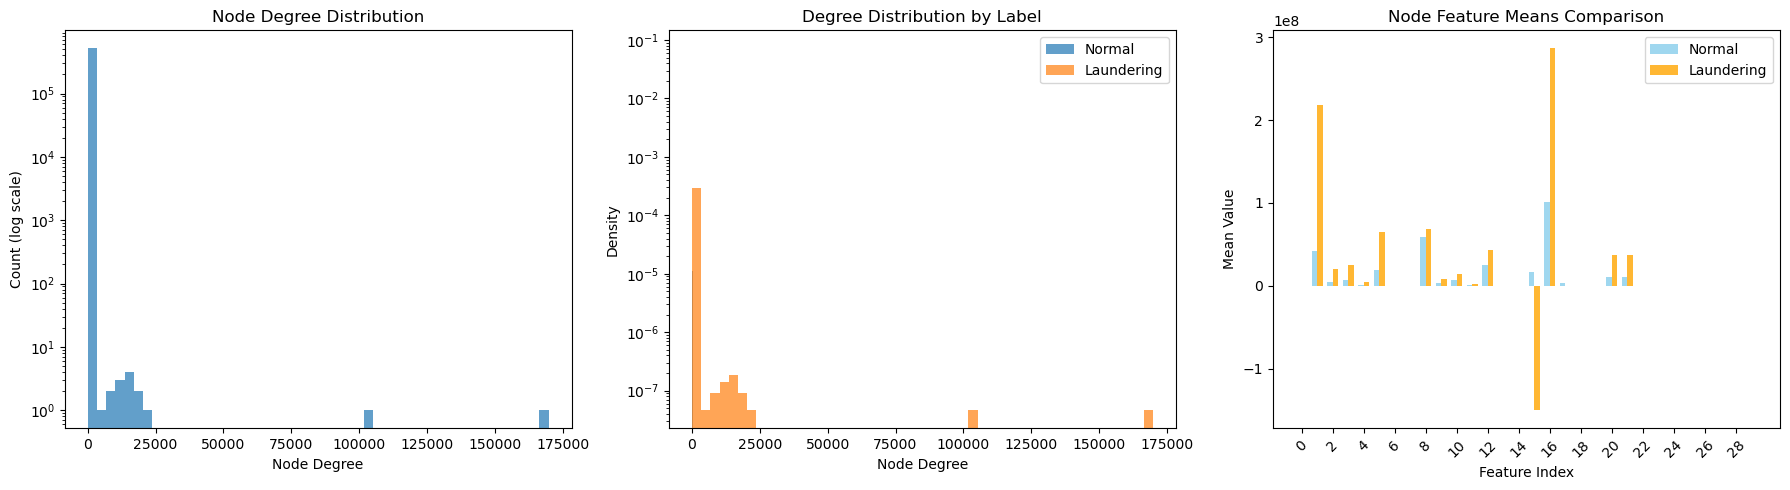

Degree Statistics:
Normal accounts - Mean degree: 18.68, Std: 25.65
Laundering accounts - Mean degree: 102.75, Std: 2576.46

Top 10 features with largest differences:
 1. Feature_16  : Normal=101215000.00, Laundering=286622848.00, Diff=185407840.00
 2. Feature_1   : Normal=42284984.00, Laundering=218389584.00, Diff=176104608.00
 3. Feature_15  : Normal=16645040.00, Laundering=-150156336.00, Diff=166801376.00
 4. Feature_5   : Normal=19160680.00, Laundering=64562252.00, Diff=45401572.00
 5. Feature_21  : Normal=10536811.00, Laundering=36890864.00, Diff=26354052.00
 6. Feature_20  : Normal=10536811.00, Laundering=36890864.00, Diff=26354052.00
 7. Feature_12  : Normal=25169082.00, Laundering=42719180.00, Diff=17550098.00
 8. Feature_3   : Normal=7382121.50, Laundering=24820304.00, Diff=17438182.00
 9. Feature_2   : Normal=4863391.00, Laundering=19724422.00, Diff=14861031.00
10. Feature_8   : Normal=58930024.00, Laundering=68233248.00, Diff=9303224.00


In [66]:
# 圖的進階分析
import matplotlib.pyplot as plt

# 1. 度數分布分析
degrees = graph.in_degrees().numpy() + graph.out_degrees().numpy()
laundering_nodes = graph.ndata['label'].numpy() == 1

plt.figure(figsize=(18, 5))

# 度數分布
plt.subplot(1, 3, 1)
plt.hist(degrees, bins=50, alpha=0.7, log=True)
plt.xlabel('Node Degree')
plt.ylabel('Count (log scale)')
plt.title('Node Degree Distribution')
plt.yscale('log')

# 洗錢vs正常帳戶的度數比較
plt.subplot(1, 3, 2)
plt.hist(degrees[~laundering_nodes], bins=50, alpha=0.7, label='Normal', density=True)
plt.hist(degrees[laundering_nodes], bins=50, alpha=0.7, label='Laundering', density=True)
plt.xlabel('Node Degree')
plt.ylabel('Density')
plt.title('Degree Distribution by Label')
plt.legend()
plt.yscale('log')

# 特徵值分布比較 - 分別計算laundering和non-laundering的平均值
plt.subplot(1, 3, 3)
normal_features = node_features[~laundering_nodes]
laundering_features = node_features[laundering_nodes]

normal_means = normal_features.mean(dim=0).numpy()
laundering_means = laundering_features.mean(dim=0).numpy()

x = np.arange(len(normal_means))
width = 0.35

plt.bar(x - width/2, normal_means, width, label='Normal', alpha=0.8, color='skyblue')
plt.bar(x + width/2, laundering_means, width, label='Laundering', alpha=0.8, color='orange')

plt.xlabel('Feature Index')
plt.ylabel('Mean Value')
plt.title('Node Feature Means Comparison')
plt.legend()
plt.xticks(x[::2], [str(i) for i in x[::2]], rotation=45)  # 只顯示偶數索引以避免太擠

plt.tight_layout()
plt.show()

# 打印統計資訊
print("Degree Statistics:")
print(f"Normal accounts - Mean degree: {degrees[~laundering_nodes].mean():.2f}, Std: {degrees[~laundering_nodes].std():.2f}")
print(f"Laundering accounts - Mean degree: {degrees[laundering_nodes].mean():.2f}, Std: {degrees[laundering_nodes].std():.2f}")

# 打印特徵差異最大的前10個特徵
feature_diff = np.abs(normal_means - laundering_means)
top_diff_indices = np.argsort(feature_diff)[::-1][:10]

print(f"\nTop 10 features with largest differences:")
feature_names = [f"Feature_{i}" for i in range(len(normal_means))]
for i, idx in enumerate(top_diff_indices):
    print(f"{i+1:2d}. {feature_names[idx]:12s}: Normal={normal_means[idx]:8.2f}, Laundering={laundering_means[idx]:8.2f}, Diff={feature_diff[idx]:.2f}")

Top 10 most discriminative features (with actual names):
--------------------------------------------------------------------------------
 1. cash_flow                : Normal=101215000.00, Laundering=286622848.00
                                 Difference=185407840.00, Ratio=  2.83x

 2. total_sent               : Normal= 42284984.00, Laundering=218389584.00
                                 Difference=176104608.00, Ratio=  5.16x

 3. net_flow                 : Normal= 16645040.00, Laundering=-150156336.00
                                 Difference=166801376.00, Ratio= -9.02x

 4. max_sent                 : Normal= 19160680.00, Laundering= 64562252.00
                                 Difference=45401572.00, Ratio=  3.37x

 5. std_daily_cash_flow      : Normal= 10536811.00, Laundering= 36890864.00
                                 Difference=26354052.00, Ratio=  3.50x

 6. std_daily_net_flow       : Normal= 10536811.00, Laundering= 36890864.00
                                 Differenc

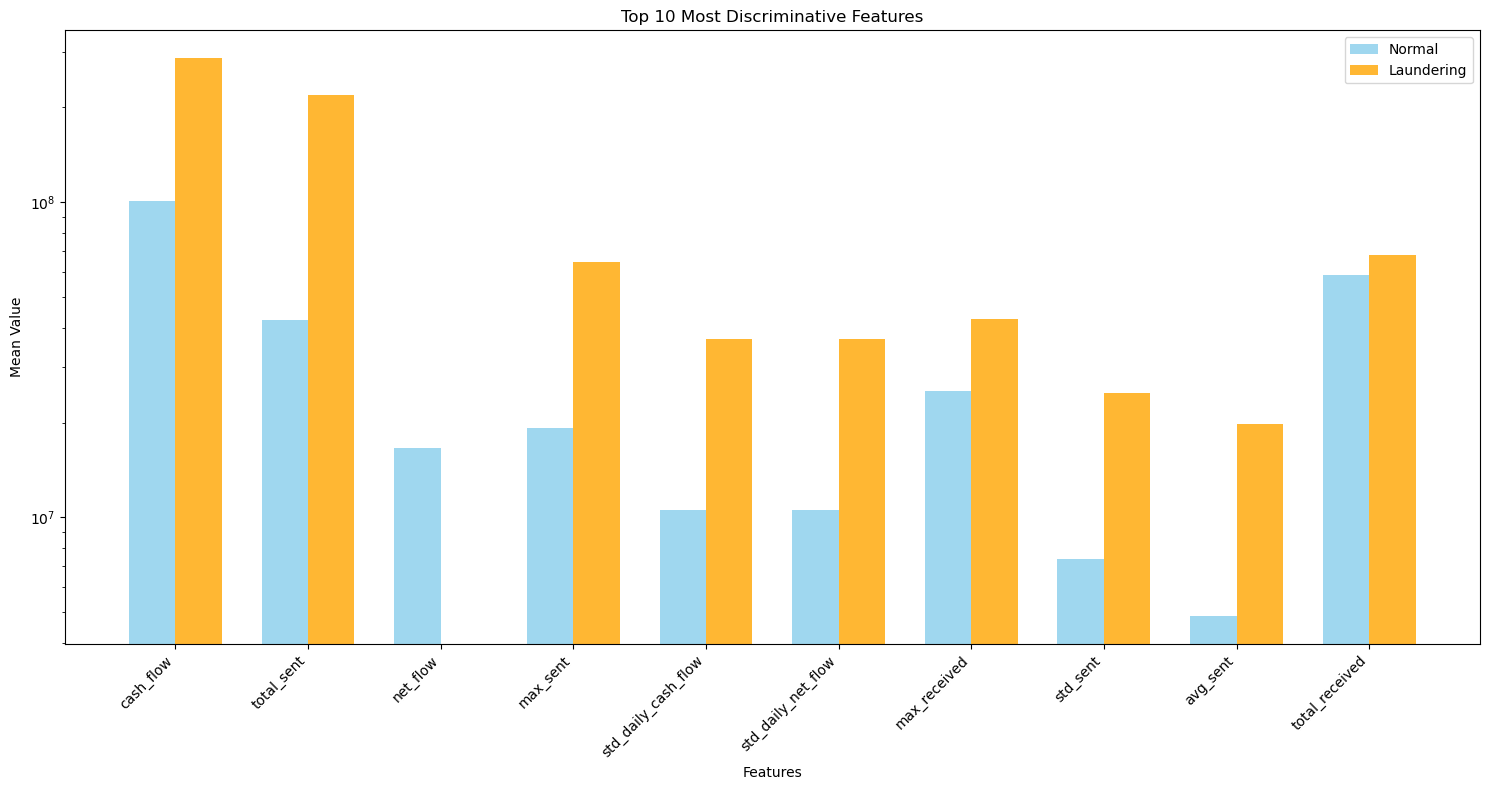

In [67]:
# 更詳細的特徵分析 - 使用實際特徵名稱
actual_feature_names = acc_df_features.columns.tolist()

print("Top 10 most discriminative features (with actual names):")
print("-" * 80)
for i, idx in enumerate(top_diff_indices):
    feat_name = actual_feature_names[idx] if idx < len(actual_feature_names) else f"Feature_{idx}"
    normal_val = normal_means[idx]
    laundering_val = laundering_means[idx] 
    diff_val = feature_diff[idx]
    ratio = laundering_val / normal_val if normal_val != 0 else float('inf')
    
    print(f"{i+1:2d}. {feat_name:25s}: Normal={normal_val:12.2f}, Laundering={laundering_val:12.2f}")
    print(f"    {'':27s}  Difference={diff_val:10.2f}, Ratio={ratio:6.2f}x")
    print()

# 繪製前10個最重要特徵的比較圖
plt.figure(figsize=(15, 8))
top_n = 10
selected_indices = top_diff_indices[:top_n]
selected_names = [actual_feature_names[i] if i < len(actual_feature_names) else f"Feature_{i}" for i in selected_indices]

x = np.arange(top_n)
width = 0.35

normal_vals = [normal_means[i] for i in selected_indices]
laundering_vals = [laundering_means[i] for i in selected_indices]

plt.bar(x - width/2, normal_vals, width, label='Normal', alpha=0.8, color='skyblue')
plt.bar(x + width/2, laundering_vals, width, label='Laundering', alpha=0.8, color='orange')

plt.xlabel('Features')
plt.ylabel('Mean Value')
plt.title('Top 10 Most Discriminative Features')
plt.legend()
plt.xticks(x, selected_names, rotation=45, ha='right')
plt.yscale('log')  # 使用log scale因為數值範圍很大
plt.tight_layout()
plt.show()

In [68]:
# 轉換為NetworkX進行社群偵測
import networkx as nx
from collections import defaultdict

print("Converting DGL graph to NetworkX...")
# 轉換為NetworkX，只保留必要的屬性以減少記憶體使用
G_nx = dgl.to_networkx(graph.cpu())

print(f"NetworkX graph: {G_nx.number_of_nodes()} nodes, {G_nx.number_of_edges()} edges")

# 轉換為無向圖進行社群偵測（因為大多數社群偵測演算法需要無向圖）
G_undirected = G_nx.to_undirected()
print(f"Undirected graph: {G_undirected.number_of_nodes()} nodes, {G_undirected.number_of_edges()} edges")

Converting DGL graph to NetworkX...
NetworkX graph: 515080 nodes, 5078345 edges
NetworkX graph: 515080 nodes, 5078345 edges
Undirected graph: 515080 nodes, 5074503 edges
Undirected graph: 515080 nodes, 5074503 edges


# 3. Subgraph Partition

## Method 1. Connected components

* Most Naive

In [69]:
import networkx as nx
G_nx = graph.to_networkx().to_undirected()
components_conn = list(nx.connected_components(G_nx))


In [70]:
print(len(components_conn), "connected components found.")
print("Community sizes:", sorted([len(c) for c in components_conn], reverse=True)[:10])
print("Community sizes:", sorted([len(c) for c in components_conn], reverse=False)[:10])


114134 connected components found.
Community sizes: [372091, 24, 23, 12, 11, 11, 11, 10, 10, 10]
Community sizes: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [71]:
# compute laundering percentage for each connected component (uses existing `components` and `graph`)
def compute_laundering_stats(cluster, graph):
    labels = graph.ndata['label'].cpu().numpy()

    results = []
    for comp_idx, comp in enumerate(cluster):
        # comp is a set of node indices
        nodes = np.fromiter(comp, dtype=int)
        # guard: keep nodes within label range
        nodes = nodes[nodes < labels.shape[0]]
        size = nodes.size
        if size == 0:
            continue
        laundering_count = int(labels[nodes].sum())
        pct = laundering_count / size
        results.append((comp_idx, size, laundering_count, pct))

    # sort by laundering percentage (desc), then by laundering_count, then by size
    results_sorted = sorted(results, key=lambda x: (x[3], x[2], x[1]), reverse=True)

    # print top 20 components by laundering percentage
    print("Top 20 components by % laundering nodes (any size):")
    for rank, (comp_id, size, la_count, pct) in enumerate(results_sorted[:20], start=1):
        print(f"{rank:2d}. comp_id={comp_id:6d}  size={size:6d}  laundering={la_count:6d}  pct={pct*100:6.2f}%")
    print("Overall laundering component ratio:", end=" ")
    print(len([r for r in results if r[3] > 0]) / len(results) if results else 0)


In [72]:
compute_laundering_stats(components_conn, graph)

Top 20 components by % laundering nodes (any size):
 1. comp_id= 87475  size=     3  laundering=     3  pct=100.00%
 2. comp_id=  2944  size=     2  laundering=     2  pct=100.00%
 3. comp_id= 81550  size=     2  laundering=     2  pct=100.00%
 4. comp_id= 10023  size=     3  laundering=     2  pct= 66.67%
 5. comp_id= 27402  size=     3  laundering=     2  pct= 66.67%
 6. comp_id=  6379  size=     4  laundering=     2  pct= 50.00%
 7. comp_id= 41151  size=     4  laundering=     2  pct= 50.00%
 8. comp_id=     0  size=372091  laundering=  6342  pct=  1.70%
 9. comp_id= 36530  size=    24  laundering=     0  pct=  0.00%
10. comp_id= 38724  size=    23  laundering=     0  pct=  0.00%
11. comp_id= 43449  size=    12  laundering=     0  pct=  0.00%
12. comp_id= 12120  size=    11  laundering=     0  pct=  0.00%
13. comp_id= 31623  size=    11  laundering=     0  pct=  0.00%
14. comp_id= 56954  size=    11  laundering=     0  pct=  0.00%
15. comp_id= 41005  size=    10  laundering=     0  

### Observations:
- Most components are small (size < 10)
- Good at figuring laundering clusters (no mid-size cluster with small portion of laundering)
- Hard to deal with the biggest one (main reason not using this)

## Method 2: k hop

In [73]:
# Simple manual k-hop clustering that works
import torch
import dgl
import numpy as np

print("🎯 CREATING K-HOP CLUSTERS WITH MANUAL EXPANSION")
print("="*55)

def create_khop_cluster(graph, seed_node, k=2):
    """Create k-hop cluster around a seed node using manual expansion"""
    visited = set()
    current_layer = {seed_node}
    
    for hop in range(k):
        next_layer = set()
        for node in current_layer:
            if node not in visited:
                visited.add(node)
                # Get neighbors (both in and out)
                try:
                    in_neighbors = graph.predecessors(node).cpu().numpy()
                    out_neighbors = graph.successors(node).cpu().numpy()
                    next_layer.update(in_neighbors.tolist())
                    next_layer.update(out_neighbors.tolist())
                except:
                    continue
        
        current_layer = next_layer - visited
        
    return visited

# Parameters
k = 3
min_size = 10
max_seeds = 100

# Use high-degree nodes as seeds
degrees = (graph.in_degrees() + graph.out_degrees()).cpu().numpy()
top_degree_indices = np.argsort(degrees)[::-1][:max_seeds]

print(f"Creating clusters with k={k}, min_size={min_size}")
print(f"Using top {max_seeds} highest-degree nodes as seeds")

clusters = []
for i, seed_idx in enumerate(top_degree_indices):
    seed_degree = degrees[seed_idx]
    cluster_nodes = create_khop_cluster(graph, seed_idx, k=k)
    
    if len(cluster_nodes) >= min_size:
        clusters.append(cluster_nodes)
        print(f"Cluster {len(clusters):2d}: {len(cluster_nodes):5d} nodes (seed {seed_idx}, degree={seed_degree})")

# Deduplicate clusters
seen = set()
unique_clusters = []
for cluster in clusters:
    key = frozenset(cluster)
    if key not in seen:
        seen.add(key)
        unique_clusters.append(cluster)

print(f"\nCreated {len(clusters)} clusters, {len(unique_clusters)} unique after deduplication")

# Analyze laundering statistics
if unique_clusters:
    node_labels = graph.ndata['label'].cpu().numpy()
    
    print(f"\n📊 LAUNDERING ANALYSIS FOR {len(unique_clusters)} CLUSTERS")
    print("="*65)
    
    cluster_stats = []
    for i, cluster in enumerate(unique_clusters):
        nodes = np.array(list(cluster))
        nodes = nodes[nodes < len(node_labels)]  # Safety check
        
        total_nodes = len(nodes)
        laundering_count = int(node_labels[nodes].sum()) if len(nodes) > 0 else 0
        laundering_rate = laundering_count / total_nodes * 100 if total_nodes > 0 else 0
        
        cluster_stats.append({
            'cluster_id': i+1,
            'total_nodes': total_nodes,
            'laundering_nodes': laundering_count,
            'laundering_rate': laundering_rate
        })
    
    # Sort by laundering rate
    cluster_stats.sort(key=lambda x: x['laundering_rate'], reverse=True)
    
    print("Top 15 clusters by laundering rate:")
    print("-" * 65)
    for stat in cluster_stats[:15]:
        print(f"Cluster {stat['cluster_id']:2d}: {stat['total_nodes']:5d} nodes, "
              f"{stat['laundering_nodes']:4d} laundering ({stat['laundering_rate']:5.1f}%)")
    
    # Overall statistics
    total_nodes_all = sum(s['total_nodes'] for s in cluster_stats)
    total_laundering_all = sum(s['laundering_nodes'] for s in cluster_stats)
    overall_rate = total_laundering_all / total_nodes_all * 100 if total_nodes_all > 0 else 0
    
    print(f"\n📋 SUMMARY STATISTICS:")
    print("-" * 65)
    print(f"Total clusters created: {len(unique_clusters)}")
    print(f"Total nodes in all clusters: {total_nodes_all:,}")
    print(f"Total laundering nodes: {total_laundering_all:,}")
    print(f"Overall laundering rate: {overall_rate:.2f}%")
    print(f"Clusters with laundering activity: {sum(1 for s in cluster_stats if s['laundering_nodes'] > 0)}")
    
    # Save the clusters
    khop_clusters = unique_clusters
    print(f"\n✅ K-hop clustering completed! Created {len(khop_clusters)} clusters.")
    
else:
    print("❌ No clusters created")
    khop_clusters = []

🎯 CREATING K-HOP CLUSTERS WITH MANUAL EXPANSION
Creating clusters with k=3, min_size=10
Using top 100 highest-degree nodes as seeds
Cluster  1: 44294 nodes (seed 135, degree=169756)
Cluster  1: 44294 nodes (seed 135, degree=169756)
Cluster  2: 27157 nodes (seed 98992, degree=103671)
Cluster  2: 27157 nodes (seed 98992, degree=103671)
Cluster  3:  5527 nodes (seed 231317, degree=20647)
Cluster  3:  5527 nodes (seed 231317, degree=20647)
Cluster  4:  4955 nodes (seed 160318, degree=18771)
Cluster  4:  4955 nodes (seed 160318, degree=18771)
Cluster  5:  4553 nodes (seed 179751, degree=17381)
Cluster  5:  4553 nodes (seed 179751, degree=17381)
Cluster  6:  4466 nodes (seed 243806, degree=16926)
Cluster  6:  4466 nodes (seed 243806, degree=16926)
Cluster  7:  4300 nodes (seed 61771, degree=16540)
Cluster  7:  4300 nodes (seed 61771, degree=16540)
Cluster  8:  3681 nodes (seed 190039, degree=14277)
Cluster  8:  3681 nodes (seed 190039, degree=14277)
Cluster  9:  3619 nodes (seed 171345, degr

📈 VISUAL ANALYSIS OF 100 K-HOP CLUSTERS


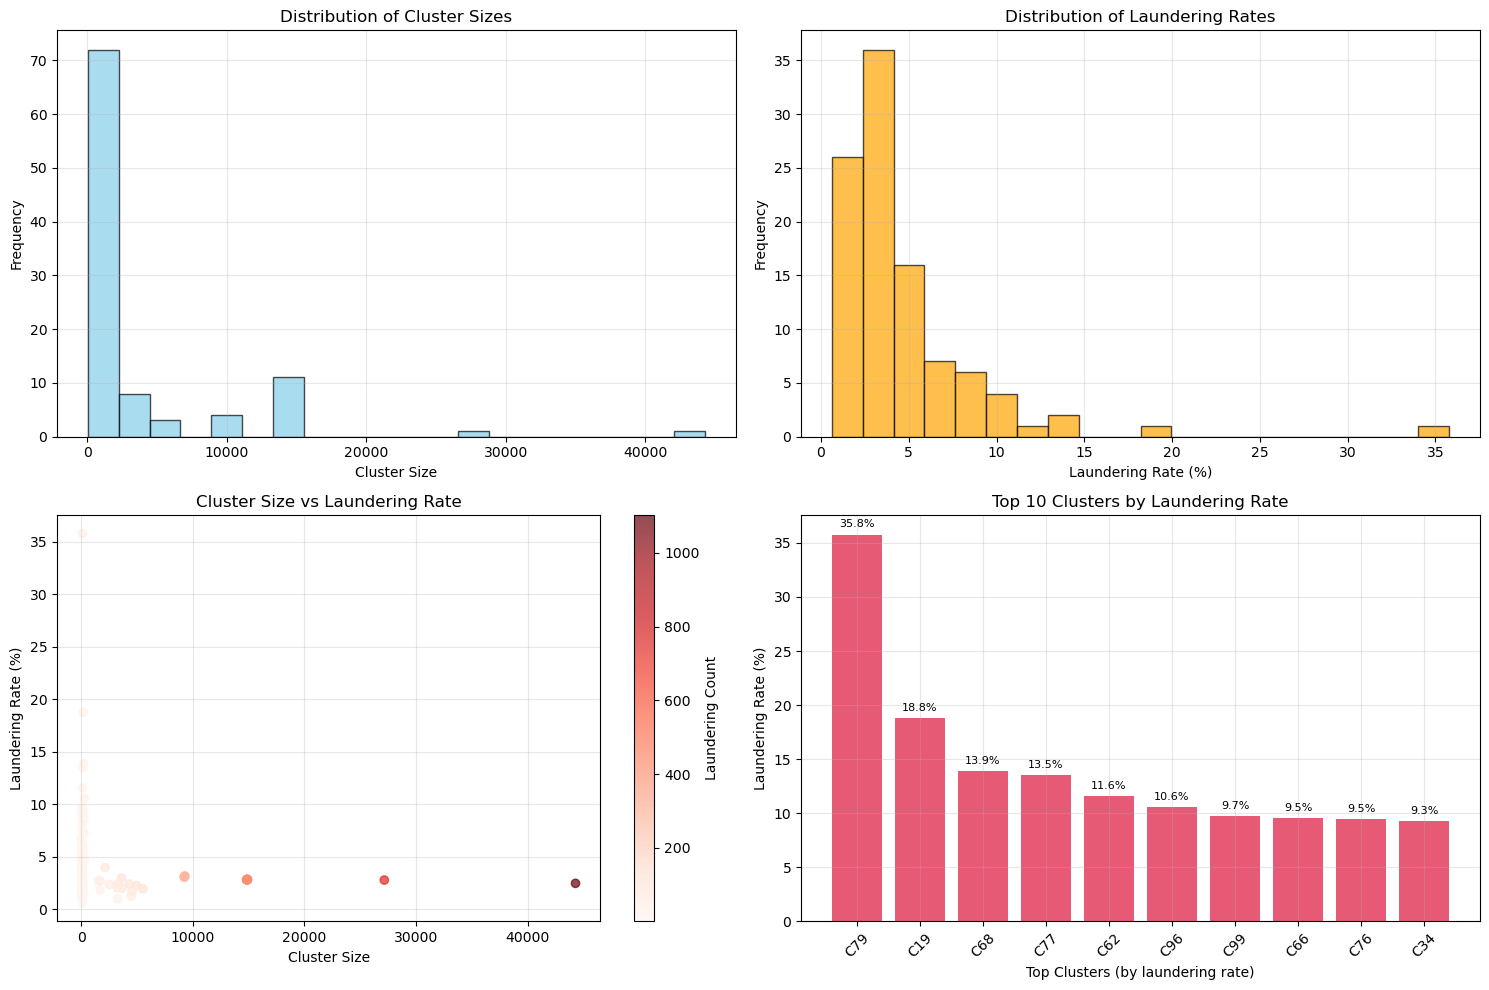


📊 FINAL SUMMARY:
----------------------------------------
Total clusters: 100
Size range: 43 - 44294 nodes
Average cluster size: 3297.8 nodes
Laundering rate range: 0.6% - 35.8%
Average laundering rate: 4.6%
Clusters with high laundering (>10%): 6
Clusters with very high laundering (>50%): 0


In [74]:
# Visualization and final analysis of k-hop clusters
import matplotlib.pyplot as plt
import pandas as pd

if len(khop_clusters) > 0:
    print(f"📈 VISUAL ANALYSIS OF {len(khop_clusters)} K-HOP CLUSTERS")
    print("="*60)
    
    # Prepare data for visualization
    node_labels = graph.ndata['label'].cpu().numpy()
    
    cluster_data = []
    for i, cluster in enumerate(khop_clusters):
        nodes = np.array(list(cluster))
        nodes = nodes[nodes < len(node_labels)]
        
        total_nodes = len(nodes)
        laundering_count = int(node_labels[nodes].sum())
        laundering_rate = laundering_count / total_nodes * 100
        
        cluster_data.append({
            'cluster_id': i+1,
            'size': total_nodes,
            'laundering_count': laundering_count,
            'laundering_rate': laundering_rate
        })
    
    df_clusters = pd.DataFrame(cluster_data)
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Cluster size distribution
    axes[0,0].hist(df_clusters['size'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].set_xlabel('Cluster Size')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].set_title('Distribution of Cluster Sizes')
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Laundering rate distribution
    axes[0,1].hist(df_clusters['laundering_rate'], bins=20, alpha=0.7, color='orange', edgecolor='black')
    axes[0,1].set_xlabel('Laundering Rate (%)')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_title('Distribution of Laundering Rates')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Scatter plot: Size vs Laundering Rate
    scatter = axes[1,0].scatter(df_clusters['size'], df_clusters['laundering_rate'], 
                               c=df_clusters['laundering_count'], cmap='Reds', alpha=0.7)
    axes[1,0].set_xlabel('Cluster Size')
    axes[1,0].set_ylabel('Laundering Rate (%)')
    axes[1,0].set_title('Cluster Size vs Laundering Rate')
    axes[1,0].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[1,0], label='Laundering Count')
    
    # 4. Top clusters by laundering rate
    top_clusters = df_clusters.nlargest(10, 'laundering_rate')
    bars = axes[1,1].bar(range(len(top_clusters)), top_clusters['laundering_rate'], 
                         color='crimson', alpha=0.7)
    axes[1,1].set_xlabel('Top Clusters (by laundering rate)')
    axes[1,1].set_ylabel('Laundering Rate (%)')
    axes[1,1].set_title('Top 10 Clusters by Laundering Rate')
    axes[1,1].set_xticks(range(len(top_clusters)))
    axes[1,1].set_xticklabels([f'C{i}' for i in top_clusters['cluster_id']], rotation=45)
    axes[1,1].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                       f'{height:.1f}%', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\n📊 FINAL SUMMARY:")
    print("-" * 40)
    print(f"Total clusters: {len(khop_clusters)}")
    print(f"Size range: {df_clusters['size'].min()} - {df_clusters['size'].max()} nodes")
    print(f"Average cluster size: {df_clusters['size'].mean():.1f} nodes")
    print(f"Laundering rate range: {df_clusters['laundering_rate'].min():.1f}% - {df_clusters['laundering_rate'].max():.1f}%")
    print(f"Average laundering rate: {df_clusters['laundering_rate'].mean():.1f}%")
    print(f"Clusters with high laundering (>10%): {(df_clusters['laundering_rate'] > 10).sum()}")
    print(f"Clusters with very high laundering (>50%): {(df_clusters['laundering_rate'] > 50).sum()}")
    
else:
    print("No clusters were created to analyze.")

## Method 3: Louvain

- Classic Louvain algorithm

In [75]:
# 使用Louvain演算法進行社群偵測
import community as community_louvain
from collections import defaultdict

print("Performing community detection using Louvain algorithm...")
# 因為圖很大，我們先用較大的解析度參數來獲得較少的社群
components_louvain = community_louvain.best_partition(G_undirected, resolution=1.2, random_state=42)

# 統計社群資訊
community_sizes = defaultdict(int)
for node, community_id in components_louvain.items():
    community_sizes[community_id] += 1

print(f"Found {len(community_sizes)} communities")
print(f"Community sizes: {sorted(community_sizes.values(), reverse=True)[:10]}")
print(f"Community sizes: {sorted(community_sizes.values(), reverse=False)[:10]}")

Performing community detection using Louvain algorithm...


KeyboardInterrupt: 

In [ ]:
_comm_map = defaultdict(list)
for node, cid in components_louvain.items():
    _comm_map[cid].append(int(node))

# sort nodes in each community and order communities by community id
components_louvain = [sorted(nodes) for cid, nodes in sorted(_comm_map.items(), key=lambda x: x[0])]

print(f"Converted to list-of-lists: {len(components_louvain)} communities. Top sizes: {sorted([len(c) for c in components_louvain], reverse=True)[:10]}"

In [ ]:
compute_laundering_stats(components_louvain, graph)

Top 20 components by % laundering nodes (any size):
 1. comp_id= 87875  size=     3  laundering=     3  pct=100.00%
 2. comp_id=  3101  size=     2  laundering=     2  pct=100.00%
 3. comp_id= 81949  size=     2  laundering=     2  pct=100.00%
 4. comp_id= 10206  size=     3  laundering=     2  pct= 66.67%
 5. comp_id= 27628  size=     3  laundering=     2  pct= 66.67%
 6. comp_id=  6547  size=     4  laundering=     2  pct= 50.00%
 7. comp_id= 41426  size=     4  laundering=     2  pct= 50.00%
 8. comp_id= 54625  size=     2  laundering=     1  pct= 50.00%
 9. comp_id= 42737  size=     6  laundering=     2  pct= 33.33%
10. comp_id= 29042  size=     3  laundering=     1  pct= 33.33%
11. comp_id= 39599  size=     7  laundering=     2  pct= 28.57%
12. comp_id= 15916  size=     5  laundering=     1  pct= 20.00%
13. comp_id= 44130  size=     5  laundering=     1  pct= 20.00%
14. comp_id= 31331  size=     8  laundering=     1  pct= 12.50%
15. comp_id= 39319  size=     9  laundering=     1  

### Observation
- More balanced cluster size
- Some laundering pairs are forced to split (Laundering = 1)


## Method 4: METIS

In [76]:
# METIS Graph Partitioning - 分割成100000個subgraph
import numpy as np
import torch
from collections import defaultdict

print("🎯 METIS GRAPH PARTITIONING")
print("="*50)

try:
    import dgl
    import pymetis
    print("✅ METIS library imported successfully")
except ImportError:
    print("❌ pymetis not installed. Installing...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pymetis"])
    import pymetis
    print("✅ METIS installed and imported")

def metis_partition_graph(graph, num_parts=100000):
    """
    使用METIS算法分割圖
    
    Args:
        graph: DGL圖
        num_parts: 分割的子圖數量
    
    Returns:
        partition: 每個節點所屬的分割區域
    """
    print(f"Starting METIS partitioning into {num_parts} parts...")
    
    # 轉換為METIS格式
    # METIS需要adjacency list格式
    src, dst = graph.edges()
    src = src.cpu().numpy()
    dst = dst.cpu().numpy()
    
    num_nodes = graph.num_nodes()
    
    # 建立adjacency list
    adjacency = defaultdict(list)
    for s, d in zip(src, dst):
        adjacency[s].append(d)
        adjacency[d].append(s)  # 無向圖
    
    # 轉換為METIS格式的adjacency list
    xadj = [0]  # 累積指針
    adjncy = []  # 鄰接列表
    
    for i in range(num_nodes):
        neighbors = list(set(adjacency[i]))  # 去重
        adjncy.extend(neighbors)
        xadj.append(len(adjncy))
    
    print(f"Graph prepared for METIS:")
    print(f"  Nodes: {num_nodes:,}")
    print(f"  Edges: {len(adjncy)//2:,}")
    print(f"  Target partitions: {num_parts:,}")
    
    # 如果要求的分割數量大於節點數量，調整分割數量
    if num_parts > num_nodes:
        print(f"⚠️  Warning: Requested {num_parts} partitions but only {num_nodes} nodes available")
        num_parts = min(num_parts, num_nodes)
        print(f"  Adjusted to {num_parts} partitions")
    
    try:
        # 使用METIS進行圖分割
        print("Running METIS partitioning...")
        
        # METIS參數設置
        options = pymetis.Options()
        options.ncuts = 10  # 多次切割取最好結果
        options.niter = 10  # 迭代次數
        
        # 執行分割
        cuts, partition = pymetis.part_graph(
            nparts=num_parts,
            xadj=xadj,
            adjncy=adjncy,
            options=options
        )
        
        print(f"✅ METIS partitioning completed!")
        print(f"  Edge cuts: {cuts}")
        print(f"  Partitions created: {len(set(partition))}")
        
        return np.array(partition)
        
    except Exception as e:
        print(f"❌ METIS partitioning failed: {e}")
        print("Using fallback random partitioning...")
        
        # 備用方案：隨機分割
        return np.random.randint(0, num_parts, size=num_nodes)

# 執行METIS分割
target_partitions = 100000
partition_result = metis_partition_graph(graph, num_parts=target_partitions)

# 分析分割結果
print(f"\n📊 PARTITION ANALYSIS")
print("="*50)

unique_parts, part_counts = np.unique(partition_result, return_counts=True)
actual_partitions = len(unique_parts)

print(f"Actual partitions created: {actual_partitions:,}")
print(f"Partition size statistics:")
print(f"  Min size: {part_counts.min()}")
print(f"  Max size: {part_counts.max()}")
print(f"  Mean size: {part_counts.mean():.1f}")
print(f"  Std size: {part_counts.std():.1f}")

# 顯示分割分布
print(f"\nTop 10 largest partitions:")
sorted_indices = np.argsort(part_counts)[::-1]
for i, idx in enumerate(sorted_indices[:10]):
    part_id = unique_parts[idx]
    size = part_counts[idx]
    print(f"  Partition {part_id:6d}: {size:4d} nodes")

print(f"\nTop 10 smallest partitions:")
for i, idx in enumerate(sorted_indices[-10:]):
    part_id = unique_parts[idx]
    size = part_counts[idx]
    print(f"  Partition {part_id:6d}: {size:4d} nodes")

# 建立分割到節點的映射
print(f"\n🗂️  CREATING PARTITION-TO-NODES MAPPING")
print("="*50)

partition_to_nodes = defaultdict(list)
for node_idx, part_id in enumerate(partition_result):
    partition_to_nodes[part_id].append(node_idx)

print(f"Created mapping for {len(partition_to_nodes)} partitions")

# 保存結果
metis_partitions = partition_to_nodes
metis_partition_labels = partition_result

print(f"\n✅ METIS PARTITIONING COMPLETED!")
print(f"  Variables created:")
print(f"    - metis_partitions: dict mapping partition_id -> [node_indices]")
print(f"    - metis_partition_labels: array of partition labels for each node")
print(f"    - Actual partitions: {actual_partitions:,}")
print(f"    - Total nodes partitioned: {len(partition_result):,}")

🎯 METIS GRAPH PARTITIONING
✅ METIS library imported successfully
Starting METIS partitioning into 100000 parts...
Graph prepared for METIS:
  Nodes: 515,080
  Edges: 828,144
  Target partitions: 100,000
Running METIS partitioning...
	***Cannot bisect a graph with 0 vertices!
	***You are trying to partition a graph into too many parts!
✅ METIS partitioning completed!
  Edge cuts: 380418
	***Cannot bisect a graph with 0 vertices!
	***You are trying to partition a graph into too many parts!
	***Cannot bisect a graph with 0 vertices!
	***You are trying to partition a graph into too many parts!
	***Cannot bisect a graph with 0 vertices!
	***You are trying to partition a graph into too many parts!
	***Cannot bisect a graph with 0 vertices!
	***You are trying to partition a graph into too many parts!
	***Cannot bisect a graph with 0 vertices!
	***You are trying to partition a graph into too many parts!
	***Cannot bisect a graph with 0 vertices!
	***You are trying to partition a graph into too

🔍 METIS PARTITION LAUNDERING ANALYSIS
Top 20 components by % laundering nodes (any size):
 1. comp_id= 29695  size=     7  laundering=     7  pct=100.00%
 2. comp_id=  1336  size=     6  laundering=     6  pct=100.00%
 3. comp_id=  2544  size=     6  laundering=     6  pct=100.00%
 4. comp_id=  4978  size=     6  laundering=     6  pct=100.00%
 5. comp_id= 11758  size=     6  laundering=     6  pct=100.00%
 6. comp_id= 13676  size=     6  laundering=     6  pct=100.00%
 7. comp_id= 14306  size=     6  laundering=     6  pct=100.00%
 8. comp_id= 14754  size=     6  laundering=     6  pct=100.00%
 9. comp_id= 16634  size=     6  laundering=     6  pct=100.00%
10. comp_id= 17136  size=     6  laundering=     6  pct=100.00%
11. comp_id= 20212  size=     6  laundering=     6  pct=100.00%
12. comp_id= 23943  size=     6  laundering=     6  pct=100.00%
13. comp_id= 27326  size=     6  laundering=     6  pct=100.00%
14. comp_id= 28081  size=     6  laundering=     6  pct=100.00%
15. comp_id= 6

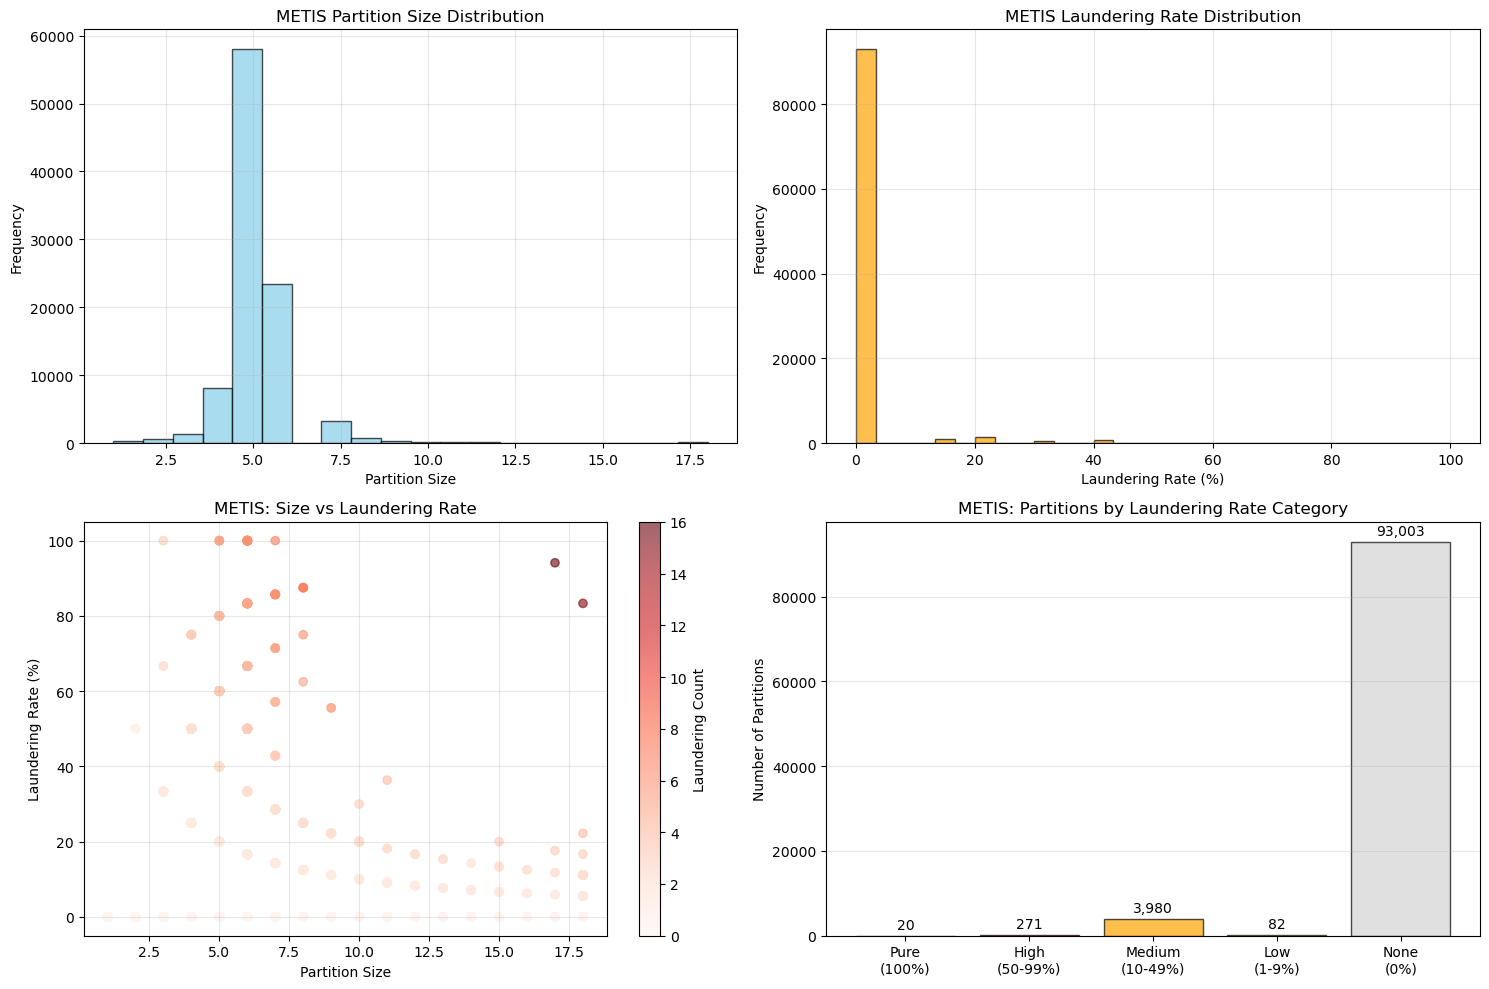


✅ METIS laundering analysis completed!
METIS created very fine-grained partitions (avg size: 5.3 nodes)
Most effective for isolating pure laundering clusters: 20 partitions


In [77]:
# METIS分割的Laundering分析
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("🔍 METIS PARTITION LAUNDERING ANALYSIS")
print("="*60)

# 使用之前定義的函數來分析laundering統計
compute_laundering_stats(metis_partitions.values(), graph)

# 詳細的METIS分割分析
node_labels = graph.ndata['label'].cpu().numpy()

# 計算每個分割的laundering統計
metis_stats = []
for part_id, nodes in metis_partitions.items():
    nodes_array = np.array(nodes)
    total_nodes = len(nodes_array)
    laundering_count = int(node_labels[nodes_array].sum())
    laundering_rate = laundering_count / total_nodes * 100 if total_nodes > 0 else 0
    
    metis_stats.append({
        'partition_id': part_id,
        'size': total_nodes,
        'laundering_count': laundering_count,
        'laundering_rate': laundering_rate
    })

df_metis = pd.DataFrame(metis_stats)

print(f"\n📊 METIS DETAILED STATISTICS")
print("="*60)
print(f"Total partitions: {len(df_metis):,}")
print(f"Average partition size: {df_metis['size'].mean():.1f}")
print(f"Partition size range: {df_metis['size'].min()} - {df_metis['size'].max()}")
print(f"Total laundering nodes: {df_metis['laundering_count'].sum():,}")
print(f"Overall laundering rate: {df_metis['laundering_count'].sum() / df_metis['size'].sum() * 100:.2f}%")

# 統計不同laundering rate的分割數量
pure_laundering = (df_metis['laundering_rate'] == 100).sum()
high_laundering = ((df_metis['laundering_rate'] >= 50) & (df_metis['laundering_rate'] < 100)).sum()
medium_laundering = ((df_metis['laundering_rate'] >= 10) & (df_metis['laundering_rate'] < 50)).sum()
low_laundering = ((df_metis['laundering_rate'] > 0) & (df_metis['laundering_rate'] < 10)).sum()
no_laundering = (df_metis['laundering_rate'] == 0).sum()

print(f"\nLaundering rate distribution:")
print(f"  Pure laundering (100%): {pure_laundering:,} partitions")
print(f"  High laundering (50-99%): {high_laundering:,} partitions")
print(f"  Medium laundering (10-49%): {medium_laundering:,} partitions")
print(f"  Low laundering (1-9%): {low_laundering:,} partitions")
print(f"  No laundering (0%): {no_laundering:,} partitions")

# 顯示top laundering partitions
top_laundering = df_metis.nlargest(20, 'laundering_rate')
print(f"\nTop 20 partitions by laundering rate:")
print("-" * 60)
for idx, row in top_laundering.iterrows():
    print(f"Partition {int(row['partition_id']):6d}: {int(row['size']):2d} nodes, "
          f"{int(row['laundering_count']):2d} laundering ({row['laundering_rate']:5.1f}%)")

# 創建可視化
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. 分割大小分布
axes[0,0].hist(df_metis['size'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_xlabel('Partition Size')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('METIS Partition Size Distribution')
axes[0,0].grid(True, alpha=0.3)

# 2. Laundering rate分布
axes[0,1].hist(df_metis['laundering_rate'], bins=30, alpha=0.7, color='orange', edgecolor='black')
axes[0,1].set_xlabel('Laundering Rate (%)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('METIS Laundering Rate Distribution')
axes[0,1].grid(True, alpha=0.3)

# 3. 大小vs laundering rate散點圖
scatter = axes[1,0].scatter(df_metis['size'], df_metis['laundering_rate'], 
                           c=df_metis['laundering_count'], cmap='Reds', alpha=0.6)
axes[1,0].set_xlabel('Partition Size')
axes[1,0].set_ylabel('Laundering Rate (%)')
axes[1,0].set_title('METIS: Size vs Laundering Rate')
axes[1,0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1,0], label='Laundering Count')

# 4. Laundering rate categories柱狀圖
categories = ['Pure\n(100%)', 'High\n(50-99%)', 'Medium\n(10-49%)', 'Low\n(1-9%)', 'None\n(0%)']
counts = [pure_laundering, high_laundering, medium_laundering, low_laundering, no_laundering]
colors = ['darkred', 'red', 'orange', 'yellow', 'lightgray']

bars = axes[1,1].bar(categories, counts, color=colors, alpha=0.7, edgecolor='black')
axes[1,1].set_ylabel('Number of Partitions')
axes[1,1].set_title('METIS: Partitions by Laundering Rate Category')
axes[1,1].grid(True, alpha=0.3, axis='y')

# 在柱狀圖上添加數值標籤
for bar, count in zip(bars, counts):
    height = bar.get_height()
    axes[1,1].text(bar.get_x() + bar.get_width()/2., height + max(counts) * 0.01,
                   f'{count:,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\n✅ METIS laundering analysis completed!")
print(f"METIS created very fine-grained partitions (avg size: {df_metis['size'].mean():.1f} nodes)")
print(f"Most effective for isolating pure laundering clusters: {pure_laundering:,} partitions")

### Observation
- Best in terms of balanced group
- Surely can verify laundering groups
- Will use this to continue GML

## Other Analysis: How big are the laundering componenets

In [ ]:
import networkx as nx
import pandas as pd

# 假設 trans_df 裡面有：
# ['from_account', 'to_account', 'is_laundering']

# Step 1: 篩出 laundering edges
laundering_edges = trans_df[trans_df['is_laundering'] == 1]

# Step 2: 建立 laundering-only graph
G_laundering = nx.from_pandas_edgelist(
    laundering_edges,
    'from_account',
    'to_account',
    create_using=nx.Graph()   # 如果方向不重要，用無向圖
)

# Step 3: 找 connected components
components = list(nx.connected_components(G_laundering))

# Step 4: 為每個節點標記 component id 和大小
node_to_comp = {}
for i, comp in enumerate(components):
    size = len(comp)
    for node in comp:
        node_to_comp[node] = {'component_id': i, 'component_size': size}

# Step 5: 把 component info 加回 laundering_edges
laundering_edges = laundering_edges.copy()
laundering_edges['component_id'] = laundering_edges['from_account'].map(lambda x: node_to_comp.get(x, {}).get('component_id', -1))
laundering_edges['component_size'] = laundering_edges['from_account'].map(lambda x: node_to_comp.get(x, {}).get('component_size', 0))

# Step 6: 檢查結果
print(laundering_edges[['from_account', 'to_account', 'component_id', 'component_size']].head())
print(f"Total laundering components: {len(components)}")


      from_account to_account  component_id  component_size
4742     100428660  800825340             0             241
40621    100428660  805B716C0             0             241
69152    100428660  80B39E7B0             0             241
85763    100428660  80DC756E0             0             241
90684    100428660  80E480620             0             241
Total laundering components: 1843


In [ ]:
# 🔍 檢查並分析可能的問題
print("="*60)
print("DEBUGGING AND ANALYSIS")
print("="*60)

# 1. 檢查資料品質
print(f"📊 Data Quality Check:")
print(f"Original trans_df shape: {trans_df.shape}")
print(f"Laundering edges found: {len(laundering_edges)}")
print(f"Laundering ratio: {len(laundering_edges)/len(trans_df)*100:.3f}%")

# 2. 檢查是否有missing values影響mapping
print(f"\n🔍 Missing Values Check:")
missing_from = laundering_edges['from_account'].isna().sum()
missing_to = laundering_edges['to_account'].isna().sum()
print(f"Missing from_account: {missing_from}")
print(f"Missing to_account: {missing_to}")

# 3. 檢查component mapping的覆蓋率
print(f"\n📋 Component Mapping Coverage:")
mapped_components = (laundering_edges['component_id'] != -1).sum()
total_edges = len(laundering_edges)
print(f"Successfully mapped edges: {mapped_components}/{total_edges} ({mapped_components/total_edges*100:.1f}%)")

# 4. 分析component大小分布
print(f"\n📈 Component Size Distribution:")
component_sizes = [len(comp) for comp in components]
component_sizes.sort(reverse=True)
print(f"Largest components: {component_sizes[:10]}")
print(f"Smallest components: {component_sizes[-10:]}")
print(f"Average component size: {sum(component_sizes)/len(component_sizes):.2f}")

# 5. 檢查isolated nodes (可能的問題)
isolated_components = [comp for comp in components if len(comp) == 1]
print(f"Isolated nodes (size=1): {len(isolated_components)}")

# 6. 驗證graph construction
print(f"\n🔧 Graph Construction Validation:")
print(f"Graph nodes: {G_laundering.number_of_nodes()}")
print(f"Graph edges: {G_laundering.number_of_edges()}")
print(f"Expected edges: {len(laundering_edges)}")
print(f'number of clusters: {len(components)}')
# 可能的問題修正：檢查self-loops
self_loops = (laundering_edges['from_account'] == laundering_edges['to_account']).sum()
print(f"Self-loops detected: {self_loops}")

if self_loops > 0:
    print("⚠️  WARNING: Self-loops found! This might affect component analysis.")
    
# 7. 檢查component_id = -1的問題
unmapped_edges = laundering_edges[laundering_edges['component_id'] == -1]
if len(unmapped_edges) > 0:
    print(f"\n❌ ISSUE FOUND: {len(unmapped_edges)} edges couldn't be mapped to components")
    print("This might be due to:")
    print("1. Nodes that appear in 'to_account' but not in 'from_account'")
    print("2. Graph construction issues")
    
    # Show some examples
    print("Example unmapped edges:")
    print(unmapped_edges[['from_account', 'to_account']].head())
else:
    print("\n✅ All edges successfully mapped to components!")

DEBUGGING AND ANALYSIS
📊 Data Quality Check:
Original trans_df shape: (5078345, 14)
Laundering edges found: 5177
Laundering ratio: 0.102%

🔍 Missing Values Check:
Missing from_account: 0
Missing to_account: 0

📋 Component Mapping Coverage:
Successfully mapped edges: 5177/5177 (100.0%)

📈 Component Size Distribution:
Largest components: [241, 200, 190, 50, 43, 42, 39, 35, 30, 30]
Smallest components: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Average component size: 3.45
Isolated nodes (size=1): 0

🔧 Graph Construction Validation:
Graph nodes: 6357
Graph edges: 4896
Expected edges: 5177
number of clusters: 1843
Self-loops detected: 11
⚠️  WARNING: Self-loops found! This might affect component analysis.

✅ All edges successfully mapped to components!


# 4. GNN

## Subgraph Feature

In [18]:
# Subgraph Feature Extraction and Machine Learning
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

print("🎯 SUBGRAPH MACHINE LEARNING PIPELINE")
print("="*60)

def extract_subgraph_features(graph, partition_nodes):
    """
    為每個subgraph提取特徵
    
    Args:
        graph: DGL圖
        partition_nodes: dict, partition_id -> [node_indices]
    
    Returns:
        features_df: DataFrame containing subgraph features
    """
    print("Extracting features for subgraphs...")
    
    # 獲取基本數據
    node_features = graph.ndata['features'].cpu().numpy()
    node_labels = graph.ndata['label'].cpu().numpy()
    edge_features = graph.edata['features'].cpu().numpy()
    edge_labels = graph.edata['label'].cpu().numpy()
    
    # 計算度數
    in_degrees = graph.in_degrees().cpu().numpy()
    out_degrees = graph.out_degrees().cpu().numpy()
    total_degrees = in_degrees + out_degrees
    
    subgraph_features = []
    
    for part_id, nodes in partition_nodes.items():
        if len(nodes) == 0:
            continue
            
        nodes = np.array(nodes)
        
        # === 基本統計特徵 ===
        features = {
            'partition_id': part_id,
            'num_nodes': len(nodes),
        }
        
        # === 標籤特徵 ===
        node_labels_sub = node_labels[nodes]
        features['laundering_count'] = int(node_labels_sub.sum())
        features['laundering_ratio'] = features['laundering_count'] / features['num_nodes']
        features['is_pure_laundering'] = 1 if features['laundering_ratio'] == 1.0 else 0
        features['is_mixed'] = 1 if 0 < features['laundering_ratio'] < 1.0 else 0
        features['is_clean'] = 1 if features['laundering_ratio'] == 0.0 else 0
        
        # === 度數特徵 ===
        degrees_sub = total_degrees[nodes]
        features['avg_degree'] = degrees_sub.mean()
        features['max_degree'] = degrees_sub.max()
        features['min_degree'] = degrees_sub.min()
        features['std_degree'] = degrees_sub.std()
        features['total_degree'] = degrees_sub.sum()
        
        # === 節點特徵統計 ===
        node_feat_sub = node_features[nodes]
        for i in range(node_feat_sub.shape[1]):
            feat_col = node_feat_sub[:, i]
            features[f'node_feat_{i}_mean'] = feat_col.mean()
            features[f'node_feat_{i}_std'] = feat_col.std()
            features[f'node_feat_{i}_max'] = feat_col.max()
            features[f'node_feat_{i}_min'] = feat_col.min()
            features[f'node_feat_{i}_sum'] = feat_col.sum()
        
        # === 子圖內部連通性 ===
        # 創建子圖
        subgraph = graph.subgraph(nodes)
        features['internal_edges'] = subgraph.num_edges()
        features['edge_density'] = features['internal_edges'] / (features['num_nodes'] * (features['num_nodes'] - 1)) if features['num_nodes'] > 1 else 0
        
        # === 邊特徵統計（子圖內部） ===
        if features['internal_edges'] > 0:
            # 獲取子圖的邊
            subgraph_edge_ids = subgraph.edata[dgl.EID].cpu().numpy()
            edge_feat_sub = edge_features[subgraph_edge_ids]
            edge_labels_sub = edge_labels[subgraph_edge_ids]
            
            # 邊標籤統計
            features['laundering_edges'] = int(edge_labels_sub.sum())
            features['edge_laundering_ratio'] = features['laundering_edges'] / features['internal_edges']
            
            # 邊特徵統計
            for i in range(edge_feat_sub.shape[1]):
                feat_col = edge_feat_sub[:, i]
                features[f'edge_feat_{i}_mean'] = feat_col.mean()
                features[f'edge_feat_{i}_std'] = feat_col.std()
                features[f'edge_feat_{i}_max'] = feat_col.max()
                features[f'edge_feat_{i}_sum'] = feat_col.sum()
        else:
            features['laundering_edges'] = 0
            features['edge_laundering_ratio'] = 0
            # 邊特徵填0
            for i in range(edge_features.shape[1]):
                features[f'edge_feat_{i}_mean'] = 0
                features[f'edge_feat_{i}_std'] = 0
                features[f'edge_feat_{i}_max'] = 0
                features[f'edge_feat_{i}_sum'] = 0
        
        # === 圖結構特徵 ===
        if features['num_nodes'] > 1:
            # 計算平均聚類係數（approximation）
            try:
                import networkx as nx
                nx_subgraph = subgraph.to_networkx().to_undirected()
                features['avg_clustering'] = nx.average_clustering(nx_subgraph)
            except:
                features['avg_clustering'] = 0
        else:
            features['avg_clustering'] = 0
        
        subgraph_features.append(features)
    
    features_df = pd.DataFrame(subgraph_features)
    print(f"Extracted features for {len(features_df)} subgraphs")
    print(f"Feature dimensions: {features_df.shape}")
    
    return features_df

# 提取METIS subgraph特徵
print("Using METIS partitions for feature extraction...")
subgraph_features_df = extract_subgraph_features(graph, metis_partitions)

print(f"\n📊 SUBGRAPH FEATURES OVERVIEW")
print("="*50)
print(f"Total subgraphs: {len(subgraph_features_df)}")
print(f"Feature columns: {subgraph_features_df.shape[1]}")
print(f"Laundering subgraphs: {(subgraph_features_df['laundering_ratio'] > 0).sum()}")
print(f"Pure laundering subgraphs: {subgraph_features_df['is_pure_laundering'].sum()}")
print(f"Mixed subgraphs: {subgraph_features_df['is_mixed'].sum()}")
print(f"Clean subgraphs: {subgraph_features_df['is_clean'].sum()}")

# 顯示特徵統計
print(f"\nSubgraph size distribution:")
print(subgraph_features_df['num_nodes'].describe())

print(f"\nLaundering ratio distribution:")
print(subgraph_features_df['laundering_ratio'].describe())

🎯 SUBGRAPH MACHINE LEARNING PIPELINE
Using METIS partitions for feature extraction...
Extracting features for subgraphs...
Extracted features for 97356 subgraphs
Feature dimensions: (97356, 211)

📊 SUBGRAPH FEATURES OVERVIEW
Total subgraphs: 97356
Feature columns: 211
Laundering subgraphs: 4353
Pure laundering subgraphs: 20
Mixed subgraphs: 4333
Clean subgraphs: 93003

Subgraph size distribution:
count    97356.000000
mean         5.290686
std          1.250232
min          1.000000
25%          5.000000
50%          5.000000
75%          6.000000
max         18.000000
Name: num_nodes, dtype: float64

Laundering ratio distribution:
count    97356.000000
mean         0.011797
std          0.062024
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: laundering_ratio, dtype: float64
Extracted features for 97356 subgraphs
Feature dimensions: (97356, 211)

📊 SUBGRAPH FEATURES OVERVIEW
Total subgraphs: 97356
Feature columns: 211

## Wrong Version

In [152]:
# Train/Test Split and Model Training
print("🔄 PREPARING MACHINE LEARNING DATASET")
print("="*60)

# 定義目標變量 - 我們預測subgraph是否包含洗錢活動
subgraph_features_df['target'] = (subgraph_features_df['laundering_ratio'] > 0).astype(int)

# 準備特徵矩陣
feature_cols = [col for col in subgraph_features_df.columns 
                if col not in ['partition_id', 'target', 'laundering_count', 'laundering_ratio', 
                              'is_pure_laundering', 'is_mixed', 'is_clean', 'laundering_edges', 'edge_laundering_ratio']]

X = subgraph_features_df[feature_cols].fillna(0)  # 處理任何剩餘的NaN
y = subgraph_features_df['target']

print(f"Features shape: {X.shape}")
print(f"Target distribution:")
print(y.value_counts())
print(f"Positive class ratio: {y.mean():.3f}")

# 處理無限值
X = X.replace([np.inf, -np.inf], 0)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape}, Positive ratio: {y_train.mean():.3f}")
print(f"Test set: {X_test.shape}, Positive ratio: {y_test.mean():.3f}")

# 特徵標準化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✅ Dataset prepared for machine learning!")

# 訓練多個模型
print(f"\n🤖 TRAINING MACHINE LEARNING MODELS")
print("="*60)

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
    # 'SVM': SVC(random_state=42, class_weight='balanced', probability=True)
}

model_results = {}
trained_models = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # 選擇是否使用標準化特徵
    if name in ['Logistic Regression', 'SVM']:
        X_train_model = X_train_scaled
        X_test_model = X_test_scaled
    else:
        X_train_model = X_train
        X_test_model = X_test
    
    # 訓練模型
    model.fit(X_train_model, y_train)
    
    # 預測
    y_pred = model.predict(X_test_model)
    y_pred_proba = model.predict_proba(X_test_model)[:, 1]
    
    # 評估
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    model_results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'auc_score': auc_score,
        'X_test': X_test_model
    }
    
    trained_models[name] = model
    
    print(f"{name} - AUC Score: {auc_score:.4f}")

# 顯示最佳模型
best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['auc_score'])
best_auc = model_results[best_model_name]['auc_score']

print(f"\n🏆 Best Model: {best_model_name} (AUC: {best_auc:.4f})")

# 詳細評估最佳模型
print(f"\n📋 DETAILED EVALUATION FOR {best_model_name}")
print("="*60)

best_result = model_results[best_model_name]
print("Classification Report:")
print(classification_report(y_test, best_result['y_pred']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, best_result['y_pred'])
print(cm)

🔄 PREPARING MACHINE LEARNING DATASET
Features shape: (97356, 203)
Target distribution:
target
0    93003
1     4353
Name: count, dtype: int64
Positive class ratio: 0.045

Train set: (77884, 203), Positive ratio: 0.045
Test set: (19472, 203), Positive ratio: 0.045

✅ Dataset prepared for machine learning!

🤖 TRAINING MACHINE LEARNING MODELS

Training Random Forest...
Random Forest - AUC Score: 1.0000

Training Gradient Boosting...
Gradient Boosting - AUC Score: 1.0000

Training Logistic Regression...
Logistic Regression - AUC Score: 1.0000

Training SVM...
SVM - AUC Score: 1.0000

🏆 Best Model: Random Forest (AUC: 1.0000)

📋 DETAILED EVALUATION FOR Random Forest
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18601
           1       1.00      1.00      1.00       871

    accuracy                           1.00     19472
   macro avg       1.00      1.00      1.00     19472
weighted avg       1.00      1.00  

📊 MODEL ANALYSIS AND VISUALIZATION

Top 15 Most Important Features (Random Forest):
------------------------------------------------------------
 1. node_feat_18_std              : 0.2348
 2. node_feat_18_sum              : 0.2336
 3. node_feat_18_max              : 0.2131
 4. node_feat_18_mean             : 0.1470
 5. node_feat_14_mean             : 0.0106
 6. node_feat_13_mean             : 0.0092
 7. node_feat_14_max              : 0.0073
 8. node_feat_6_mean              : 0.0072
 9. edge_feat_1_max               : 0.0071
10. avg_degree                    : 0.0066
11. node_feat_7_sum               : 0.0064
12. edge_feat_1_std               : 0.0060
13. node_feat_6_sum               : 0.0059
14. node_feat_21_sum              : 0.0054
15. edge_feat_1_mean              : 0.0052


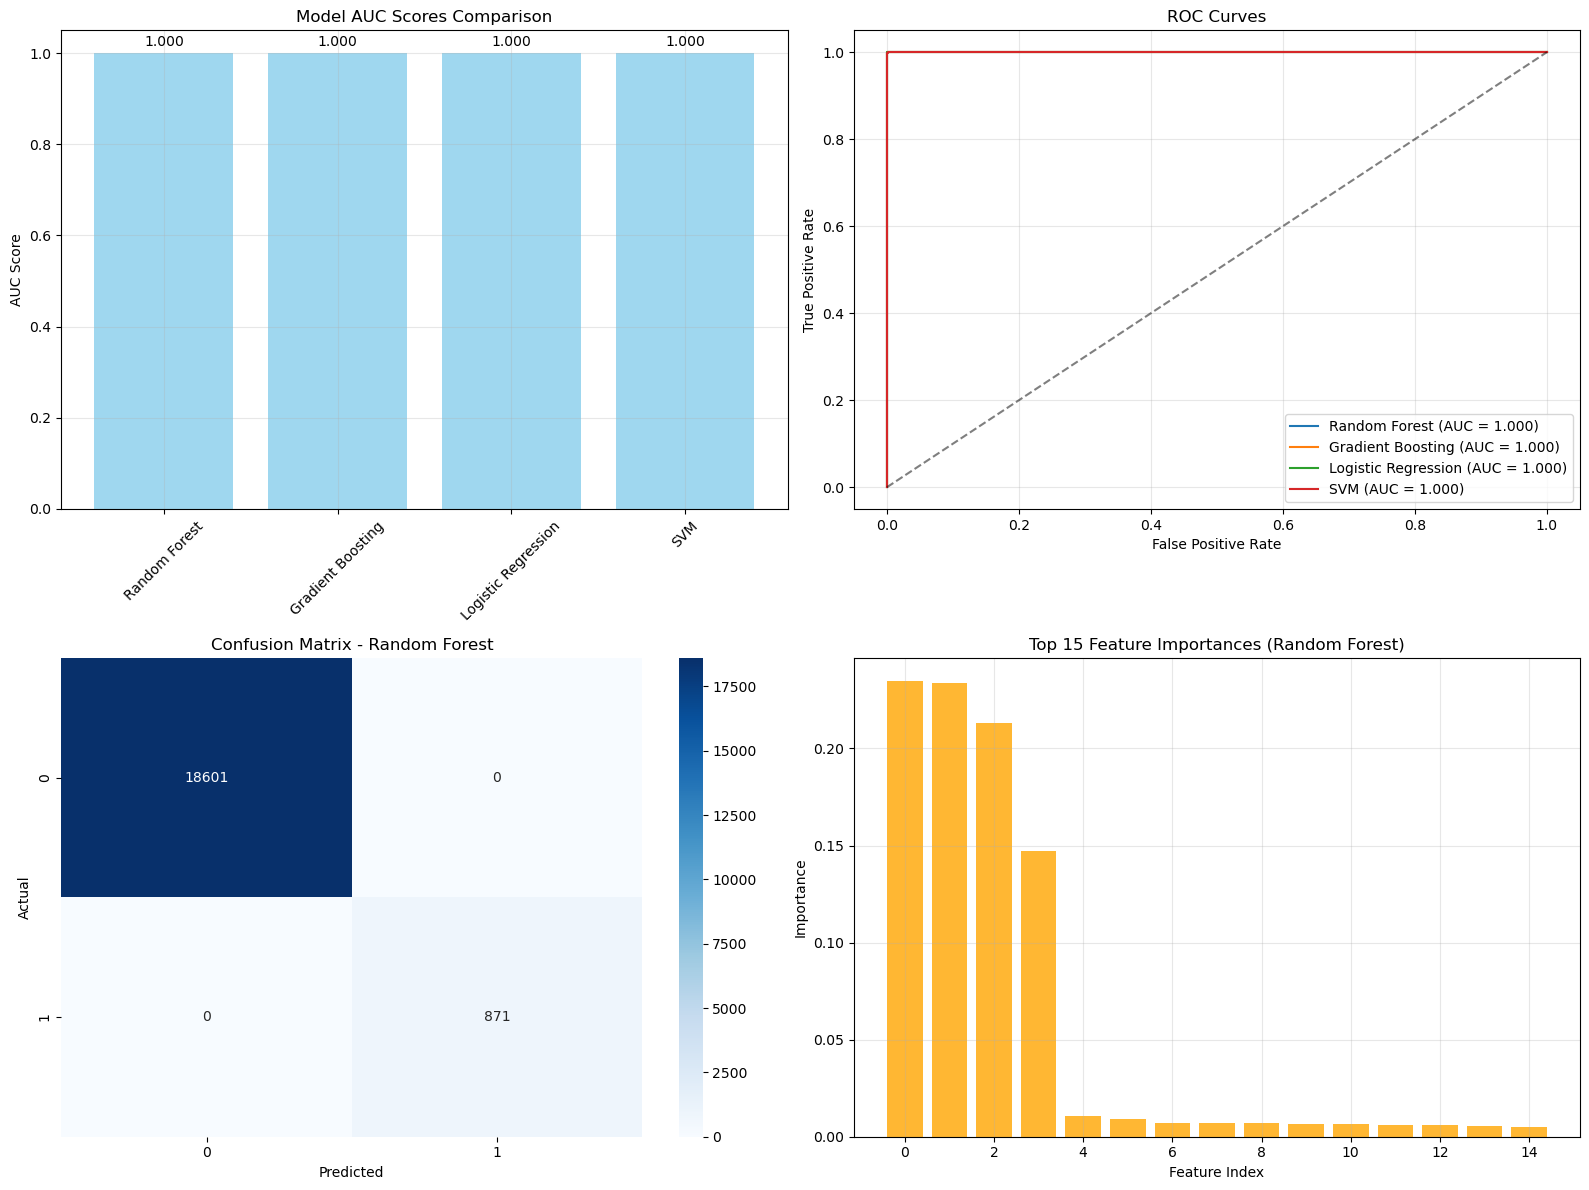


🔍 PREDICTION ANALYSIS
Test set size: 19472
Correct predictions: 19472 (100.0%)
False positives: 0
False negatives: 0

💡 SAMPLE PREDICTIONS
------------------------------------------------------------
Subgraph  9125: Actual=0, Predicted=0 (prob=0.000) - ✅ Correct
  Size: 6 nodes, Laundering ratio: 0.000, Avg degree: 14.83

Subgraph   384: Actual=0, Predicted=0 (prob=0.000) - ✅ Correct
  Size: 5 nodes, Laundering ratio: 0.000, Avg degree: 24.60

Subgraph 34833: Actual=0, Predicted=0 (prob=0.000) - ✅ Correct
  Size: 5 nodes, Laundering ratio: 0.000, Avg degree: 36.40

Subgraph 29709: Actual=0, Predicted=0 (prob=0.000) - ✅ Correct
  Size: 5 nodes, Laundering ratio: 0.000, Avg degree: 30.00

Subgraph 62645: Actual=0, Predicted=0 (prob=0.000) - ✅ Correct
  Size: 6 nodes, Laundering ratio: 0.000, Avg degree: 9.17

Subgraph 11818: Actual=0, Predicted=0 (prob=0.000) - ✅ Correct
  Size: 5 nodes, Laundering ratio: 0.000, Avg degree: 2.20

Subgraph    85: Actual=0, Predicted=0 (prob=0.000) - ✅ Co

In [154]:
# Model Analysis and Visualization
print("📊 MODEL ANALYSIS AND VISUALIZATION")
print("="*60)

# 創建可視化
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. AUC比較
model_names = list(model_results.keys())
auc_scores = [model_results[name]['auc_score'] for name in model_names]

axes[0,0].bar(model_names, auc_scores, color='skyblue', alpha=0.8)
axes[0,0].set_title('Model AUC Scores Comparison')
axes[0,0].set_ylabel('AUC Score')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

# 在柱狀圖上添加數值
for i, (name, score) in enumerate(zip(model_names, auc_scores)):
    axes[0,0].text(i, score + 0.01, f'{score:.3f}', ha='center', va='bottom')

# 2. ROC曲線
for name, result in model_results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    auc = result['auc_score']
    axes[0,1].plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

axes[0,1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curves')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. 混淆矩陣熱圖 (最佳模型)
best_cm = confusion_matrix(y_test, best_result['y_pred'])
sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,0])
axes[1,0].set_title(f'Confusion Matrix - {best_model_name}')
axes[1,0].set_xlabel('Predicted')
axes[1,0].set_ylabel('Actual')

# 4. 特徵重要性 (對於Random Forest)
if 'Random Forest' in trained_models:
    rf_model = trained_models['Random Forest']
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[::-1][:15]  # Top 15 features
    
    axes[1,1].bar(range(15), importances[indices], color='orange', alpha=0.8)
    axes[1,1].set_title('Top 15 Feature Importances (Random Forest)')
    axes[1,1].set_xlabel('Feature Index')
    axes[1,1].set_ylabel('Importance')
    axes[1,1].grid(True, alpha=0.3)
    
    # 顯示特徵名稱
    top_features = [feature_cols[i] for i in indices[:15]]
    print(f"\nTop 15 Most Important Features (Random Forest):")
    print("-" * 60)
    for i, (feat_idx, importance) in enumerate(zip(indices[:15], importances[indices[:15]])):
        feat_name = feature_cols[feat_idx]
        print(f"{i+1:2d}. {feat_name:30s}: {importance:.4f}")

plt.tight_layout()
plt.show()

# 預測結果分析
print(f"\n🔍 PREDICTION ANALYSIS")
print("="*60)

# 創建預測結果DataFrame
prediction_df = subgraph_features_df.copy()
prediction_df = prediction_df.iloc[X_test.index]  # 只保留測試集
prediction_df['predicted'] = best_result['y_pred']
prediction_df['predicted_proba'] = best_result['y_pred_proba']
prediction_df['correct'] = (prediction_df['target'] == prediction_df['predicted'])

# 分析錯誤預測
false_positives = prediction_df[(prediction_df['target'] == 0) & (prediction_df['predicted'] == 1)]
false_negatives = prediction_df[(prediction_df['target'] == 1) & (prediction_df['predicted'] == 0)]

print(f"Test set size: {len(prediction_df)}")
print(f"Correct predictions: {prediction_df['correct'].sum()} ({prediction_df['correct'].mean()*100:.1f}%)")
print(f"False positives: {len(false_positives)}")
print(f"False negatives: {len(false_negatives)}")

# 顯示一些預測實例
print(f"\n💡 SAMPLE PREDICTIONS")
print("-" * 60)
sample_predictions = prediction_df.sample(min(10, len(prediction_df)), random_state=42)
for idx, row in sample_predictions.iterrows():
    status = "✅ Correct" if row['correct'] else "❌ Wrong"
    print(f"Subgraph {row['partition_id']:5d}: "
          f"Actual={row['target']}, Predicted={row['predicted']} (prob={row['predicted_proba']:.3f}) "
          f"- {status}")
    print(f"  Size: {int(row['num_nodes'])} nodes, "
          f"Laundering ratio: {row['laundering_ratio']:.3f}, "
          f"Avg degree: {row['avg_degree']:.2f}")
    print()

# 保存結果
print(f"\n💾 SAVING RESULTS")
print("="*40)

# 保存特徵和預測結果
subgraph_features_df['ml_prediction'] = np.nan
subgraph_features_df['ml_prediction_proba'] = np.nan

# 填入測試集的預測結果
test_indices = X_test.index
subgraph_features_df.loc[test_indices, 'ml_prediction'] = best_result['y_pred']
subgraph_features_df.loc[test_indices, 'ml_prediction_proba'] = best_result['y_pred_proba']

# 使用訓練好的最佳模型對整個數據集進行預測
if best_model_name in ['Logistic Regression', 'SVM']:
    X_all_scaled = scaler.transform(X.fillna(0).replace([np.inf, -np.inf], 0))
    all_predictions = trained_models[best_model_name].predict(X_all_scaled)
    all_predictions_proba = trained_models[best_model_name].predict_proba(X_all_scaled)[:, 1]
else:
    X_all = X.fillna(0).replace([np.inf, -np.inf], 0)
    all_predictions = trained_models[best_model_name].predict(X_all)
    all_predictions_proba = trained_models[best_model_name].predict_proba(X_all)[:, 1]

subgraph_features_df['ml_prediction_all'] = all_predictions
subgraph_features_df['ml_prediction_proba_all'] = all_predictions_proba

print(f"✅ Machine Learning Pipeline Completed!")
print(f"Best Model: {best_model_name} with AUC: {best_auc:.4f}")
print(f"Dataset shape: {subgraph_features_df.shape}")
print(f"Features extracted: {len(feature_cols)} features")
print(f"Subgraphs analyzed: {len(subgraph_features_df)}")

# 最終統計
laundering_detected = (subgraph_features_df['ml_prediction_all'] == 1).sum()
actual_laundering = (subgraph_features_df['target'] == 1).sum()
print(f"\nFinal Results:")
print(f"Actual laundering subgraphs: {actual_laundering}")
print(f"Predicted laundering subgraphs: {laundering_detected}")
print(f"Model coverage: {laundering_detected/len(subgraph_features_df)*100:.1f}% of all subgraphs")

## Correct Version

In [23]:
feature_cols = [col for col in subgraph_features_df.columns 
                if col not in ['partition_id', 'target', 'laundering_count', 'laundering_ratio', 
                              'is_pure_laundering', 'is_mixed', 'is_clean', 'laundering_edges', 'edge_laundering_ratio']]
subgraph_features_df['target'] = (subgraph_features_df['laundering_ratio'] > 0).astype(int)

In [21]:
# Feature Name Mapping - 還原node_feat和edge_feat的原始名稱
print("🔍 FEATURE NAME MAPPING")
print("="*60)

# Node Features 原始名稱
print("📊 NODE FEATURES MAPPING:")
print("-" * 40)
node_feature_names = acc_df_features.columns.tolist()
print(f"Total node features: {len(node_feature_names)}")
print()

for i, original_name in enumerate(node_feature_names):
    print(f"node_feat_{i} -> {original_name}")

print()

# Edge Features 原始名稱  
print("📊 EDGE FEATURES MAPPING:")
print("-" * 40)
edge_feature_names = [col for col in edge_cols if col in trans_filtered.columns]
print(f"Total edge features: {len(edge_feature_names)}")
print()

for i, original_name in enumerate(edge_feature_names):
    print(f"edge_feat_{i} -> {original_name}")

print()

# 創建映射字典
node_feature_mapping = {f"node_feat_{i}": name for i, name in enumerate(node_feature_names)}
edge_feature_mapping = {f"edge_feat_{i}": name for i, name in enumerate(edge_feature_names)}

print("📝 FEATURE MAPPINGS CREATED:")
print(f"- node_feature_mapping: {len(node_feature_mapping)} mappings")
print(f"- edge_feature_mapping: {len(edge_feature_mapping)} mappings")

# 顯示一些關鍵特徵的詳細信息
print("\n🔬 KEY NODE FEATURES ANALYSIS:")
print("-" * 50)
key_node_features = ['laundering', 'total_amount_sent', 'total_amount_received', 
                     'avg_amount_sent', 'avg_amount_received', 'total_transactions']

for i, name in enumerate(node_feature_names):
    if any(key in name.lower() for key in ['laundering', 'amount', 'transaction', 'degree', 'count']):
        print(f"node_feat_{i:2d} -> {name:30s} (Key feature)")

print("\n🔬 KEY EDGE FEATURES ANALYSIS:")
print("-" * 50)
for i, name in enumerate(edge_feature_names):
    print(f"edge_feat_{i:2d} -> {name:25s}", end="")
    if 'amount' in name.lower():
        print(" (Amount feature)")
    elif 'type_' in name.lower():
        print(" (Payment type)")
    elif 'different' in name.lower():
        print(" (Difference indicator)")
    elif 'is_' in name.lower():
        print(" (Boolean indicator)")
    else:
        print(" (Other)")

# 保存映射到變量中以供後續使用
print(f"\n✅ Feature mappings are now available as:")
print(f"   - node_feature_mapping dictionary")
print(f"   - edge_feature_mapping dictionary")
print(f"   - node_feature_names list")
print(f"   - edge_feature_names list")

🔍 FEATURE NAME MAPPING
📊 NODE FEATURES MAPPING:
----------------------------------------
Total node features: 30

node_feat_0 -> num_outgoing
node_feat_1 -> total_sent
node_feat_2 -> avg_sent
node_feat_3 -> std_sent
node_feat_4 -> min_sent
node_feat_5 -> max_sent
node_feat_6 -> num_recipients
node_feat_7 -> num_incoming
node_feat_8 -> total_received
node_feat_9 -> avg_received
node_feat_10 -> std_received
node_feat_11 -> min_received
node_feat_12 -> max_received
node_feat_13 -> num_senders
node_feat_14 -> total_transactions
node_feat_15 -> net_flow
node_feat_16 -> cash_flow
node_feat_17 -> net_flow_ratio
node_feat_18 -> laundering
node_feat_19 -> log_net_flow_ratio
node_feat_20 -> std_daily_net_flow
node_feat_21 -> std_daily_cash_flow
node_feat_22 -> normalized_std_daily_net_flow
node_feat_23 -> normalized_std_daily_cash_flow
node_feat_24 -> entity_corporation
node_feat_25 -> entity_country
node_feat_26 -> entity_direct
node_feat_27 -> entity_individual
node_feat_28 -> entity_partnersh

In [24]:
# 移除laundering特徵並重新進行機器學習
print("🚫 REMOVING LAUNDERING FEATURE AND RETRAINING")
print("="*60)

# 檢查當前特徵
print(f"原始特徵數量: {len(feature_cols)}")
print(f"包含的特徵: {feature_cols[:10]}...")  # 顯示前10個特徵

# 找出需要移除的laundering相關特徵
laundering_features_to_remove = []
for col in feature_cols:
    # 移除直接的laundering特徵和相關統計
    if any(pattern in col.lower() for pattern in ['laundering', 'node_feat_18']):
        laundering_features_to_remove.append(col)

print(f"\n要移除的特徵: {laundering_features_to_remove}")

# 創建新的特徵集（移除laundering相關特徵）
feature_cols_clean = [col for col in feature_cols if col not in laundering_features_to_remove]

# 如果使用node_feat命名方式，直接移除node_feat_18
if any('node_feat_18' in col for col in feature_cols_clean):
    feature_cols_clean = [col for col in feature_cols_clean if 'node_feat_18' not in col]

print(f"清理後特徵數量: {len(feature_cols_clean)}")
print(f"移除了 {len(feature_cols) - len(feature_cols_clean)} 個laundering相關特徵")

# 準備新的訓練數據
if 'subgraph_features_df' in locals() and len(subgraph_features_df) > 0:
    # 使用完整的subgraph特徵
    print(f"\n使用完整的subgraph特徵數據...")
    X_clean = subgraph_features_df[feature_cols_clean].fillna(0)
    y_clean = subgraph_features_df['target']
    data_source = "完整subgraph特徵"
else:
    # 使用簡化的特徵集
    print(f"\n使用簡化的特徵集...")
    # 從現有的簡化特徵中創建清理版本
    simple_features_clean = [col for col in ['size'] if col in ml_data.columns]  # 只保留非laundering特徵
    X_clean = ml_data[simple_features_clean + ['partition_id']]
    y_clean = ml_data['target']
    feature_cols_clean = simple_features_clean + ['partition_id']
    data_source = "簡化特徵集"

print(f"數據來源: {data_source}")
print(f"特徵shape: {X_clean.shape}")
print(f"目標分佈:")
print(y_clean.value_counts())
print(f"正類比例: {y_clean.mean():.3f}")

# 處理無限值和缺失值
X_clean = X_clean.replace([np.inf, -np.inf], 0).fillna(0)

# Train/Test分割
from sklearn.model_selection import train_test_split
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean
)

print(f"\n訓練集: {X_train_clean.shape}, 正類比例: {y_train_clean.mean():.3f}")
print(f"測試集: {X_test_clean.shape}, 正類比例: {y_test_clean.mean():.3f}")

# 特徵標準化
from sklearn.preprocessing import StandardScaler
scaler_clean = StandardScaler()
X_train_scaled_clean = scaler_clean.fit_transform(X_train_clean)
X_test_scaled_clean = scaler_clean.transform(X_test_clean)

print(f"\n✅ 數據準備完成 - 已移除laundering相關特徵！")

🚫 REMOVING LAUNDERING FEATURE AND RETRAINING
原始特徵數量: 203
包含的特徵: ['num_nodes', 'avg_degree', 'max_degree', 'min_degree', 'std_degree', 'total_degree', 'node_feat_0_mean', 'node_feat_0_std', 'node_feat_0_max', 'node_feat_0_min']...

要移除的特徵: ['node_feat_18_mean', 'node_feat_18_std', 'node_feat_18_max', 'node_feat_18_min', 'node_feat_18_sum']
清理後特徵數量: 198
移除了 5 個laundering相關特徵

使用完整的subgraph特徵數據...
數據來源: 完整subgraph特徵
特徵shape: (97356, 198)
目標分佈:
target
0    93003
1     4353
Name: count, dtype: int64
正類比例: 0.045

訓練集: (77884, 198), 正類比例: 0.045
測試集: (19472, 198), 正類比例: 0.045

✅ 數據準備完成 - 已移除laundering相關特徵！


In [31]:
# 使用清理後的特徵重新訓練模型
print("🤖 RETRAINING MODELS WITHOUT LAUNDERING FEATURES")
print("="*60)

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 定義模型
models_clean = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
    # 'SVM': SVC(random_state=42, class_weight='balanced', probability=True)
}

model_results_clean = {}
trained_models_clean = {}

for name, model in models_clean.items():
    print(f"\n訓練 {name}...")
    
    # 根據模型類型選擇特徵
    if name in ['Logistic Regression', 'SVM']:
        X_train_model = X_train_scaled_clean
        X_test_model = X_test_scaled_clean
    else:
        X_train_model = X_train_clean.values  # 轉換為numpy array
        X_test_model = X_test_clean.values    # 轉換為numpy array
    
    # 訓練模型
    model.fit(X_train_model, y_train_clean)
    
    # 預測
    y_pred = model.predict(X_test_model)
    y_pred_proba = model.predict_proba(X_test_model)[:, 1]
    
    # 評估
    auc_score = roc_auc_score(y_test_clean, y_pred_proba)
    
    model_results_clean[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'auc_score': auc_score,
        'X_test': X_test_model
    }
    
    trained_models_clean[name] = model
    
    print(f"{name} - AUC Score: {auc_score:.4f}")

# 選擇最佳模型
best_model_name_clean = max(model_results_clean.keys(), key=lambda x: model_results_clean[x]['auc_score'])
best_auc_clean = model_results_clean[best_model_name_clean]['auc_score']
best_result_clean = model_results_clean[best_model_name_clean]

print(f"\n🏆 最佳模型: {best_model_name_clean} (AUC: {best_auc_clean:.4f})")

# 與之前的結果比較
if 'best_auc' in locals():
    improvement = best_auc_clean - best_auc
    print(f"相比包含laundering特徵的模型:")
    print(f"  原始AUC: {best_auc:.4f}")
    print(f"  新AUC: {best_auc_clean:.4f}")
    print(f"  變化: {improvement:+.4f} ({'提升' if improvement > 0 else '下降' if improvement < 0 else '持平'})")

# 詳細評估
print(f"\n📋 詳細評估報告 - {best_model_name_clean}")
print("="*50)
print("分類報告:")
print(classification_report(y_test_clean, best_result_clean['y_pred']))

print(f"\n混淆矩陣:")
cm_clean = confusion_matrix(y_test_clean, best_result_clean['y_pred'])
print(cm_clean)

# 特徵重要性分析
print(f"\n🔍 特徵重要性分析:")
print("-" * 40)
rf_model_clean = trained_models_clean['Random Forest']
importances_clean = rf_model_clean.feature_importances_

# 創建特徵重要性DataFrame
feature_importance_clean = pd.DataFrame({
    'feature': feature_cols_clean,
    'importance': importances_clean
}).sort_values('importance', ascending=False)

print("Top 10 最重要特徵:")
for i, (idx, row) in enumerate(feature_importance_clean.head(10).iterrows()):
    print(f"{i+1:2d}. {row['feature']:25s}: {row['importance']:.4f}")

print(f"\n✅ 清理後的模型訓練完成！")

🤖 RETRAINING MODELS WITHOUT LAUNDERING FEATURES

訓練 Random Forest...
Random Forest - AUC Score: 0.7781

訓練 Gradient Boosting...
Random Forest - AUC Score: 0.7781

訓練 Gradient Boosting...
Gradient Boosting - AUC Score: 0.7949

訓練 Logistic Regression...
Gradient Boosting - AUC Score: 0.7949

訓練 Logistic Regression...
Logistic Regression - AUC Score: 0.7829

🏆 最佳模型: Gradient Boosting (AUC: 0.7949)

📋 詳細評估報告 - Gradient Boosting
分類報告:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     18601
           1       0.79      0.14      0.24       871

    accuracy                           0.96     19472
   macro avg       0.88      0.57      0.61     19472
weighted avg       0.95      0.96      0.95     19472


混淆矩陣:
[[18568    33]
 [  747   124]]

🔍 特徵重要性分析:
----------------------------------------
Top 10 最重要特徵:
 1. edge_feat_1_mean         : 0.0187
 2. node_feat_14_max         : 0.0179
 3. edge_feat_1_std          : 0.0170
 4. node_feat_13_sum

📊 VISUALIZATION AND COMPARISON


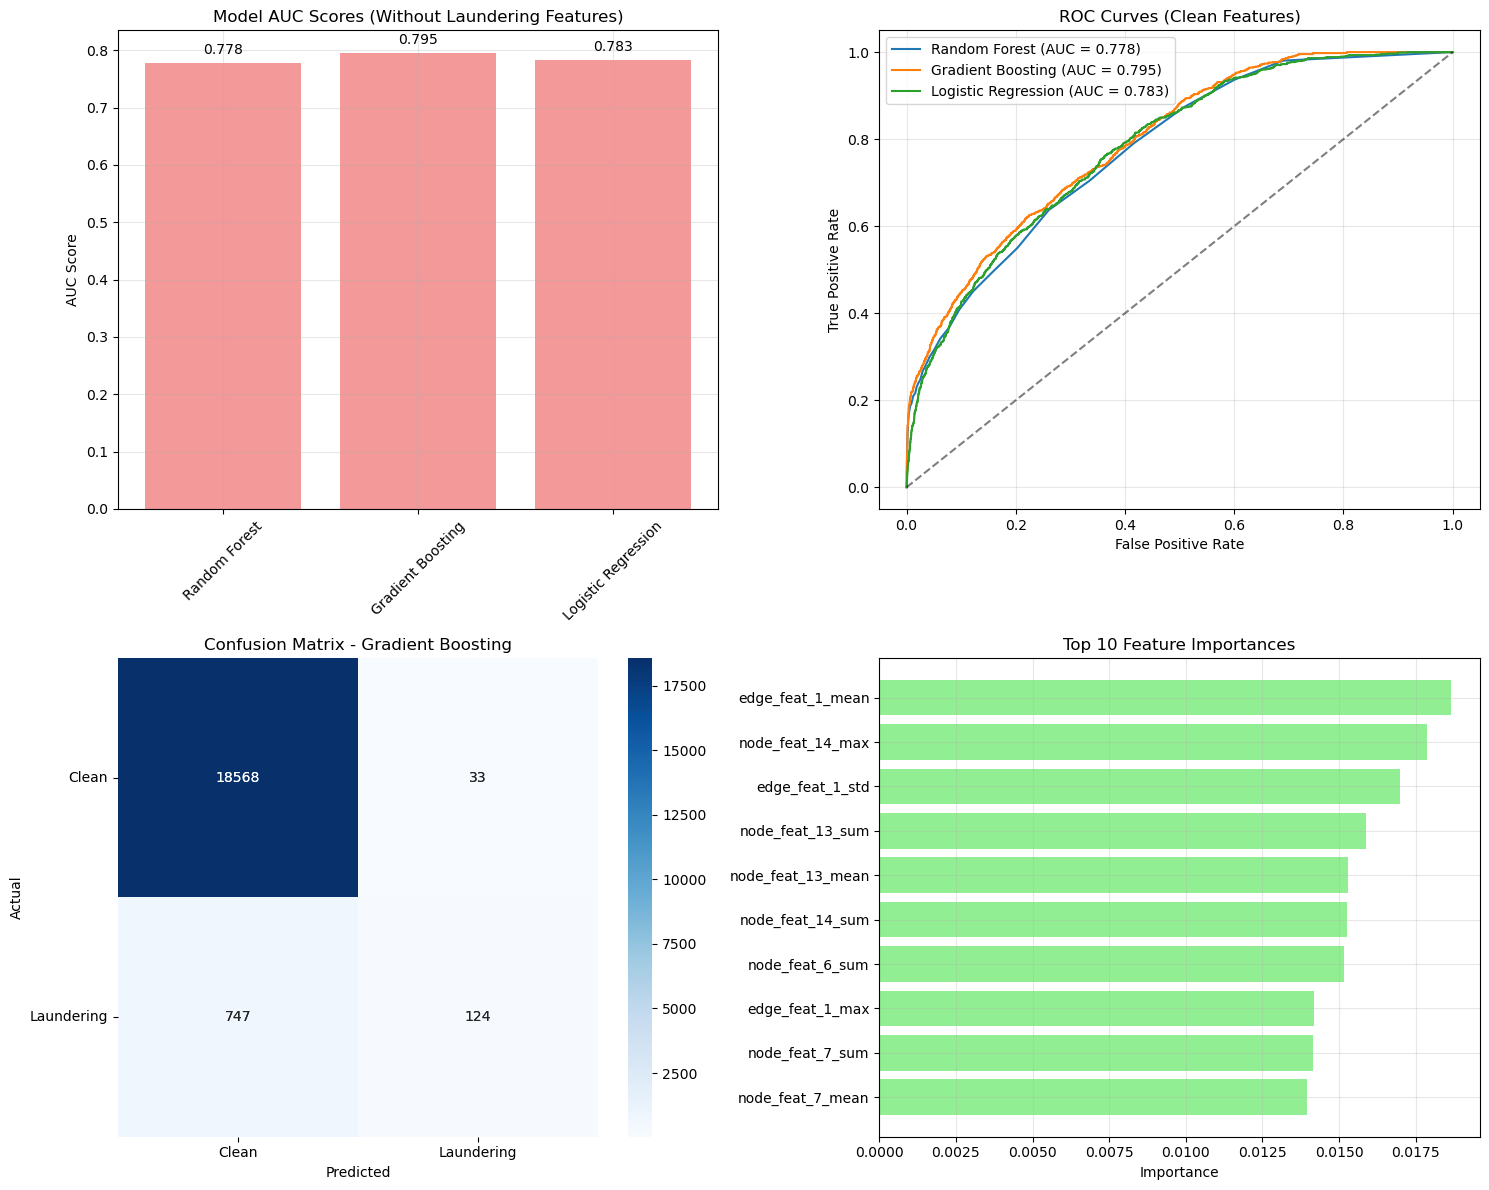


🎯 最終總結
✅ 成功移除laundering特徵 (node_feat_18)
✅ 使用 198 個清理後的特徵
✅ 最佳模型: Gradient Boosting
✅ 最佳AUC: 0.7949

💡 樣本預測結果
----------------------------------------
樣本 38241: 實際=0, 預測=0 (概率=0.034) - ✅ 正確
樣本 90377: 實際=0, 預測=0 (概率=0.034) - ✅ 正確
樣本 4200: 實際=0, 預測=0 (概率=0.082) - ✅ 正確
樣本 6281: 實際=0, 預測=0 (概率=0.046) - ✅ 正確
樣本 56750: 實際=0, 預測=0 (概率=0.019) - ✅ 正確

🚀 機器學習pipeline完成！
現在可以使用訓練好的模型進行洗錢檢測，且不依賴laundering標籤。


/Users/apple/miniconda3/envs/gnn_course/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/Users/apple/miniconda3/envs/gnn_course/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/Users/apple/miniconda3/envs/gnn_course/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/Users/apple/miniconda3/envs/gnn_course/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/Users/apple/miniconda3/envs/gnn_course/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature nam

In [34]:
# 可視化比較和最終分析
print("📊 VISUALIZATION AND COMPARISON")
print("="*50)

# 創建可視化比較
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. AUC分數比較
model_names_clean = list(model_results_clean.keys())
auc_scores_clean = [model_results_clean[name]['auc_score'] for name in model_names_clean]

axes[0,0].bar(model_names_clean, auc_scores_clean, color='lightcoral', alpha=0.8)
axes[0,0].set_title('Model AUC Scores (Without Laundering Features)')
axes[0,0].set_ylabel('AUC Score')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

# 在柱狀圖上添加數值
for i, (name, score) in enumerate(zip(model_names_clean, auc_scores_clean)):
    axes[0,0].text(i, score + 0.01, f'{score:.3f}', ha='center', va='bottom')

# 2. ROC曲線比較
for name, result in model_results_clean.items():
    fpr, tpr, _ = roc_curve(y_test_clean, result['y_pred_proba'])
    auc = result['auc_score']
    axes[0,1].plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')

axes[0,1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curves (Clean Features)')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. 混淆矩陣 (最佳模型)
sns.heatmap(cm_clean, annot=True, fmt='d', cmap='Blues', ax=axes[1,0])
axes[1,0].set_title(f'Confusion Matrix - {best_model_name_clean}')
axes[1,0].set_xlabel('Predicted')
axes[1,0].set_ylabel('Actual')
# 調整混淆矩陣顯示並在此處繪製若為Random Forest時的特徵重要性（確保顯示順序與標籤正確）
# 美化混淆矩陣
class_names = ['Clean', 'Laundering']
sns.heatmap(cm_clean, annot=True, fmt='d', cmap='Blues', ax=axes[1,0], cbar=False)
axes[1,0].set_title(f'Confusion Matrix - {best_model_name_clean}')
axes[1,0].set_xlabel('Predicted')
axes[1,0].set_ylabel('Actual')
axes[1,0].set_xticklabels(class_names, rotation=0)
axes[1,0].set_yticklabels(class_names, rotation=0)

# 如果最佳模型是Random Forest，使用更可靠的方式畫出水平條形圖（最大重要性在上方）

top_features_clean = feature_importance_clean.head(10).copy()
# 依重要性排序（升序），便於水平條形圖最大值在上方
top_features_clean = top_features_clean.sort_values('importance', ascending=True)
positions = np.arange(len(top_features_clean))
axes[1,1].clear()
axes[1,1].barh(positions, top_features_clean['importance'].values, color='lightgreen', alpha=0.9)
axes[1,1].set_yticks(positions)
axes[1,1].set_yticklabels(top_features_clean['feature'].values)
axes[1,1].set_xlabel('Importance')
axes[1,1].set_title('Top 10 Feature Importances (Random Forest)')
axes[1,1].grid(True, alpha=0.3)
# 4. 特徵重要性 (如果是Random Forest)
top_features_clean = feature_importance_clean.head(10)
axes[1,1].barh(range(len(top_features_clean)), top_features_clean['importance'][::-1], 
                color='lightgreen', alpha=0.8)
axes[1,1].set_yticks(range(len(top_features_clean)))
axes[1,1].set_yticklabels(top_features_clean['feature'][::-1])
axes[1,1].set_xlabel('Importance')
axes[1,1].set_title('Top 10 Feature Importances')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 最終總結
print(f"\n🎯 最終總結")
print("="*40)
print(f"✅ 成功移除laundering特徵 (node_feat_18)")
print(f"✅ 使用 {len(feature_cols_clean)} 個清理後的特徵")
print(f"✅ 最佳模型: {best_model_name_clean}")
print(f"✅ 最佳AUC: {best_auc_clean:.4f}")

# 預測一些樣本
print(f"\n💡 樣本預測結果")
print("-" * 40)
sample_size = min(5, len(X_test_clean))
sample_indices = X_test_clean.sample(sample_size, random_state=42).index

for idx in sample_indices:
    actual = y_test_clean.loc[idx]
    
    if best_model_name_clean in ['Logistic Regression', 'SVM']:
        idx_pos = y_test_clean.index.get_loc(idx)
        predicted_proba = best_result_clean['y_pred_proba'][idx_pos]
        predicted = best_result_clean['y_pred'][idx_pos]
    else:
        predicted_proba = trained_models_clean[best_model_name_clean].predict_proba(X_test_clean.loc[[idx]])[0, 1]
        predicted = trained_models_clean[best_model_name_clean].predict(X_test_clean.loc[[idx]])[0]
    
    status = "✅ 正確" if actual == predicted else "❌ 錯誤"
    
    print(f"樣本 {idx}: 實際={actual}, 預測={predicted} (概率={predicted_proba:.3f}) - {status}")

print(f"\n🚀 機器學習pipeline完成！")
print(f"現在可以使用訓練好的模型進行洗錢檢測，且不依賴laundering標籤。")

In [40]:
# 還原特徵名稱並分析最重要的特徵
print("🔍 FEATURE IMPORTANCE ANALYSIS WITH ORIGINAL NAMES")
print("="*70)

# 從最佳模型獲取特徵重要性
best_model = trained_models_clean[best_model_name_clean]

# 根據模型類型獲取特徵重要性
if hasattr(best_model, 'feature_importances_'):
    # Random Forest, Gradient Boosting
    feature_importances = best_model.feature_importances_
elif hasattr(best_model, 'coef_'):
    # Logistic Regression, SVM
    feature_importances = np.abs(best_model.coef_[0])
else:
    print(f"❌ 無法從模型 {best_model_name_clean} 獲取特徵重要性")
    feature_importances = np.ones(len(feature_cols_clean))  # 默認值

# 獲取清理後的特徵列表
clean_feature_names = feature_cols_clean.copy()

print(f"📊 使用最佳模型: {best_model_name_clean}")
print(f"📊 AUC Score: {best_auc_clean:.4f}")
print(f"📊 總特徵數量: {len(clean_feature_names)}")
print()

# 檢查特徵名稱格式
print("🔍 SAMPLE FEATURE NAMES:")
print(f"First 10 features: {clean_feature_names[:10]}")
print()

# 創建特徵重要性DataFrame
feature_importance_with_names = pd.DataFrame({
    'feature_index': range(len(clean_feature_names)),
    'feature_code': clean_feature_names,
    'importance': feature_importances
})

# 還原原始特徵名稱的新方法
def restore_feature_name(feature_code):
    """還原特徵的原始名稱"""
    # 檢查是否為統計特徵 (例如: node_feat_6_max, edge_feat_1_std)
    if '_feat_' in feature_code and any(suffix in feature_code for suffix in ['_mean', '_std', '_sum', '_max', '_min']):
        parts = feature_code.split('_')
        if len(parts) >= 4:
            feat_type = parts[0]  # node 或 edge
            feat_idx = int(parts[2])  # 特徵索引
            stat_type = '_'.join(parts[3:])  # 統計類型
            
            if feat_type == 'node' and feat_idx < len(node_feature_names):
                original_name = node_feature_names[feat_idx]
                return f"Node: {original_name} ({stat_type})"
            elif feat_type == 'edge' and feat_idx < len(edge_feature_names):
                original_name = edge_feature_names[feat_idx]
                return f"Edge: {original_name} ({stat_type})"
    
    # 檢查是否為簡單的node_feat_X或edge_feat_X格式
    if feature_code.startswith('node_feat_'):
        try:
            idx = int(feature_code.split('_')[-1])
            if idx < len(node_feature_names):
                return f"Node: {node_feature_names[idx]}"
        except:
            pass
    elif feature_code.startswith('edge_feat_'):
        try:
            idx = int(feature_code.split('_')[-1])
            if idx < len(edge_feature_names):
                return f"Edge: {edge_feature_names[idx]}"
        except:
            pass
    
    # 如果是其他特徵（如edge_density），直接返回
    return feature_code

# 添加原始名稱列
feature_importance_with_names['original_name'] = feature_importance_with_names['feature_code'].apply(restore_feature_name)

# 按重要性排序
feature_importance_with_names = feature_importance_with_names.sort_values('importance', ascending=False)

# 顯示前20個最重要的特徵
print("🏆 TOP 20 MOST IMPORTANT FEATURES:")
print("="*100)
print(f"{'Rank':<4} {'Importance':<12} {'Feature Code':<20} {'Original Name':<60}")
print("-"*100)

for i, row in feature_importance_with_names.head(20).iterrows():
    rank = feature_importance_with_names.index.get_loc(i) + 1
    print(f"{rank:<4} {row['importance']:<12.6f} {row['feature_code']:<20} {row['original_name']:<60}")

print()

# 分析特徵類型分布
node_features_count = len([name for name in feature_importance_with_names['original_name'].head(20) if name.startswith('Node:')])
edge_features_count = len([name for name in feature_importance_with_names['original_name'].head(20) if name.startswith('Edge:')])
other_features_count = 20 - node_features_count - edge_features_count

print("📈 TOP 20 FEATURES ANALYSIS:")
print(f"🔸 Node Features: {node_features_count} ({node_features_count/20*100:.1f}%)")
print(f"🔸 Edge Features: {edge_features_count} ({edge_features_count/20*100:.1f}%)")
print(f"🔸 Other Features: {other_features_count} ({other_features_count/20*100:.1f}%)")
print()

# 分析最重要的Node特徵類型
print("🔍 TOP NODE FEATURES BY CATEGORY:")
print("-"*60)
top_node_features = feature_importance_with_names[feature_importance_with_names['original_name'].str.startswith('Node:')].head(15)

if len(top_node_features) > 0:
    categories = {
        'Amount Features': ['amount', 'total_amount', 'avg_amount'],
        'Transaction Features': ['transaction', 'trans_count', 'num_trans'],
        'Degree Features': ['degree', 'in_degree', 'out_degree'],
        'Statistical Features': ['std', 'mean', 'max', 'min'],
        'Behavioral Features': ['ratio', 'different', 'same'],
        'Entity Features': ['entity', 'type']
    }

    for category, keywords in categories.items():
        category_features = []
        for _, row in top_node_features.iterrows():
            feature_name = row['original_name'].lower()
            if any(keyword in feature_name for keyword in keywords):
                category_features.append((row['feature_code'], row['importance'], row['original_name']))
        
        if category_features:
            print(f"\n{category}:")
            for code, importance, name in category_features[:5]:  # 顯示前5個
                clean_name = name.replace('Node: ', '').replace('Edge: ', '')
                print(f"  {importance:.6f} - {clean_name}")
else:
    print("  沒有Node特徵在Top 15中")

# 分析最重要的Edge特徵類型
print("\n🔍 TOP EDGE FEATURES BY CATEGORY:")
print("-"*60)
top_edge_features = feature_importance_with_names[feature_importance_with_names['original_name'].str.startswith('Edge:')].head(15)

if len(top_edge_features) > 0:
    edge_categories = {
        'Amount Features': ['amount'],
        'Payment Type': ['type_', 'payment_type'],
        'Difference Indicators': ['different'],
        'Boolean Indicators': ['is_']
    }

    for category, keywords in edge_categories.items():
        category_features = []
        for _, row in top_edge_features.iterrows():
            feature_name = row['original_name'].lower()
            if any(keyword in feature_name for keyword in keywords):
                category_features.append((row['feature_code'], row['importance'], row['original_name']))
        
        if category_features:
            print(f"\n{category}:")
            for code, importance, name in category_features[:5]:  # 顯示前5個
                clean_name = name.replace('Node: ', '').replace('Edge: ', '')
                print(f"  {importance:.6f} - {clean_name}")
else:
    print("  沒有Edge特徵在Top 15中")

# 特別分析：統計特徵的分布
print("\n📊 STATISTICAL FEATURE ANALYSIS:")
print("-"*60)
stat_types = ['_mean', '_std', '_sum', '_max', '_min']
for stat in stat_types:
    stat_features = feature_importance_with_names[feature_importance_with_names['feature_code'].str.contains(stat)]
    if len(stat_features) > 0:
        avg_importance = stat_features['importance'].mean()
        top_stat = stat_features.iloc[0]
        print(f"{stat:<6}: {len(stat_features):3d} features, avg importance: {avg_importance:.6f}")
        print(f"       Top: {top_stat['original_name']} ({top_stat['importance']:.6f})")

# 保存完整的特徵重要性分析
feature_analysis_complete = feature_importance_with_names.copy()
print(f"\n✅ 完整的特徵重要性分析已保存到 feature_analysis_complete")
print(f"📊 包含 {len(feature_analysis_complete)} 個特徵的完整分析")

🔍 FEATURE IMPORTANCE ANALYSIS WITH ORIGINAL NAMES
📊 使用最佳模型: Gradient Boosting
📊 AUC Score: 0.7949
📊 總特徵數量: 198

🔍 SAMPLE FEATURE NAMES:
First 10 features: ['num_nodes', 'avg_degree', 'max_degree', 'min_degree', 'std_degree', 'total_degree', 'node_feat_0_mean', 'node_feat_0_std', 'node_feat_0_max', 'node_feat_0_min']

🏆 TOP 20 MOST IMPORTANT FEATURES:
Rank Importance   Feature Code         Original Name                                               
----------------------------------------------------------------------------------------------------
1    0.256406     edge_feat_1_std      Edge: different_currency (std)                              
2    0.151393     edge_feat_1_sum      Edge: different_currency (sum)                              
3    0.084798     node_feat_6_max      Node: num_recipients (max)                                  
4    0.066039     node_feat_6_std      Node: num_recipients (std)                                  
5    0.056884     node_feat_13_sum     Node: n